### Anomaly detection with Multihead Latent Attention + DeepSeek MoE



In [1]:
import os
import sys
# Move up one directory
os.chdir("..")
path_models_lib = os.path.join(os.getcwd(), "models")
assert os.path.isdir(path_models_lib), "No folder models"
# Add the parent directory to sys.path
sys.path.append(path_models_lib)

In [2]:
import math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
from torch import nn
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

from einops import rearrange
import torch.optim as optim
import torch.utils.data as data
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

## tqdm for loading bars
# from tqdm import tqdm
from tqdm.notebook import tqdm


plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms



from models.MLA_MOE.MLA import ModelArgs,  Transformer, Gate


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "C:/Users/Miguel/Documents/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "C:/Users/Miguel/Documents/Malky/research/saved_models/mla_Moe_anomalyDetection"


torch.set_float32_matmul_precision('high')
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


In [4]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    # 
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [5]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

In [6]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [7]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

In [8]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [9]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [10]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [11]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)
batch_size = 1024
num_workers =  0

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=batch_size, shuffle=True,  drop_last=True,  num_workers=num_workers, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

<Figure size 640x480 with 0 Axes>

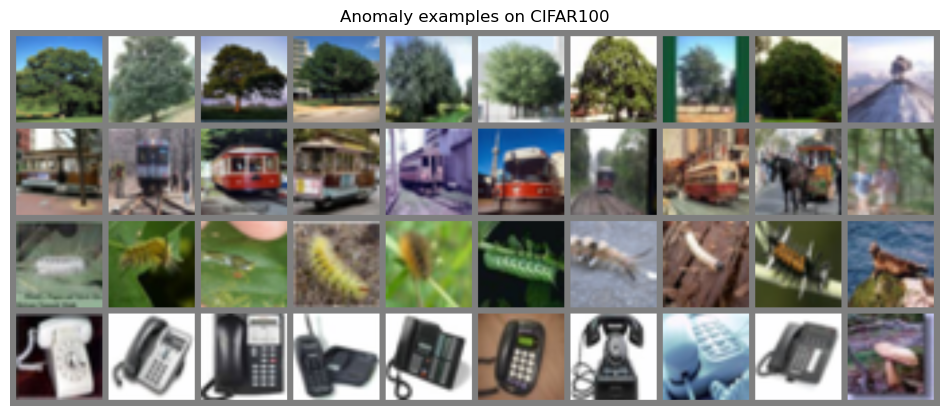

In [12]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

SET MODEL

In [34]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [35]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args, **kwargs):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        self.save_hyperparameters()

        dropout_out = kwargs.get("dropout_out", 0.1)
        self.warmup = kwargs.get('warmup', 50)
        self.max_iters = kwargs.get('max_iters', 50)
        self.lr = kwargs.get("lr", 1e-6 )
        self.alpha_route_bias_loss = kwargs.get("alpha_route_bias_loss", 1e-4 )
        self.print_moe_experts = kwargs.get("print_experts", False)

        self.vocab_size = args.vocab_size
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_out),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x

        # x, expert_assignments = self.transformer(tokens=x, mask=mask, start_pos=start_pos)
        # x = self.output_net(x)
        # return x, expert_assignments


    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
  
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.warmup ,
                                             max_iters=self.max_iters)
         

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "interval": "step"  # Adjust learning rate per step
            }
        }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        """
        Called at the end of each training batch to update the bias terms in all Gate modules.

        Args:
            outputs: The output of the training_step (e.g., loss).
            batch: The current batch of data.
            batch_idx: The index of the current batch.
        """
        for module in self.modules():
            if isinstance(module, Gate):
                module.update_bias()

In [36]:
class AnomalyPredictor(TransformerPredictor):


    def _calculate_loss(self, batch, mode="train")-> Tuple[torch.Tensor, float]:
        # Fetch data and transform categories to one-hot vectors
       
        img_sets, _, labels = batch
        # preds = self.forward(img_sets, mask=None, start_pos=0) 
        preds = self.forward(img_sets, mask=None, start_pos=0)  # Shape: (batch_size, seq_len, vocab_size)
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]


        loss = nn.functional.cross_entropy(preds, labels) + self.alpha_route_bias_loss * torch.sum(torch.stack(self.transformer.get_complementary_sequence_wise_aux_for_loss()))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)

        if mode == "train":
            if self.print_moe_experts:
                print(self.transformer.get_expert_assignments())

        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [37]:
def train_anomaly(args, **kwargs):

    max_epochs = kwargs.get("max_epochs", 10)
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    EarlyStopping(monitor='val_acc', patience=20, mode="max")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
       
        model = AnomalyPredictor(args,**kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, train_anom_loader, verbose=False)
    val_result = trainer.test(model, val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

Version 0

- Train accuracy: 98.45%
- Val accuracy:   93.08%
- Test accuracy:  92.20%

Version 1

Indices with mistake: [  1  35  40  49  64  72  92 103 107 112 115 134 143 159 168 185 210 214 221 250]

- Train accuracy: 98.34%
- Val accuracy:   92.36%
- Test accuracy:  92.57%

In [38]:
dim = 512
n_routed_experts = 6

args = ModelArgs()

args.input_dim = train_anom_dataset.img_feats.shape[-1]             # Match ResNet output 512
args.max_batch_size = batch_size        # Larger batch size for stability in anomaly detection
args.max_seq_len = 512          # Match your embedding dimension (or adjust if needed)
args.vocab_size = 1             # Output detection
args.dim = dim                  # Match ResNet embedding dimension
args.inter_dim = dim  * 2         # Standard FFN expansion factor (2x dim)
args.n_layers = 3               # Deeper model for better feature learning
args.n_heads = 2               # Balanced attention heads


# LoRA (optional for efficiency)
args.q_lora_rank = 32          # Lower rank for LoRA (adjust if needed)
args.kv_lora_rank = 32
args.qk_nope_head_dim = 64       # Head dim without positional embeddings
args.qk_rope_head_dim = 64       # Head dim with RoPE
args.v_head_dim = 32         # Value head dim
args.dropout= 0.2             # Regularization for anomaly detection

# MoE Configuration (Key Focus)
args.n_routed_experts = n_routed_experts        # 4 routed experts (as requested)
args.n_shared_experts = 1        # 1 shared expert (as requested)
args.n_activated_experts = 3     # Activate 2 experts per token (common practice)
args.n_expert_groups = 1        # Single group unless you need parallelism
args.n_limited_groups = 1        # k groups 
args.score_func= "sigmoid"  # Standard choice
args.route_scale= 1.0         # No scaling
args.moe_inter_dim = (dim * 2 )// n_routed_experts
args.n_dense_layers = 1  # First layer is dense, second is MoE



train = {
    "dropout_out":0.2,
    "warmup" : 200,
    "max_iters": int(200 * batch_size),
    "lr": 3.8e-4,
    "alpha_route_bias_loss":1.2e-3,
    "max_epochs": 200,
    "print_experts": True
    }


anomaly_model, anomaly_result = train_anomaly(args=args, **train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | transformer | Transformer | 5.7 M  | train
1 | output_net  | Sequential  | 263 K  | train
----------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.035    Total estimated model params size (MB)
130       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5279, 4416, 1880, 8540, 9296, 1309])), (2, tensor([5562, 7636, 2703, 3226, 7021, 4572]))]
[(1, tensor([5330, 4395, 1883, 8553, 9228, 1331])), (2, tensor([5434, 7743, 2623, 3311, 7113, 4496]))]
[(1, tensor([5476, 4183, 1954, 8444, 9333, 1330])), (2, tensor([5678, 7585, 2703, 3325, 6916, 4513]))]
[(1, tensor([5340, 4511, 1975, 8303, 9218, 1373])), (2, tensor([5450, 7878, 2833, 3455, 6752, 4352]))]
[(1, tensor([5307, 4688, 2029, 8239, 9088, 1369])), (2, tensor([5770, 7765, 2863, 3519, 6466, 4337]))]
[(1, tensor([5352, 4624, 2275, 7917, 8975, 1577])), (2, tensor([5853, 7512, 3077, 3640, 6400, 4238]))]
[(1, tensor([5355, 4876, 2350, 7686, 8746, 1707])), (2, tensor([5983, 7345, 3180, 3849, 6190, 4173]))]
[(1, tensor([5293, 4861, 2745, 7381, 8559, 1881])), (2, tensor([6017, 7173, 3390, 4038, 5998, 4104]))]
[(1, tensor([5135, 5233, 2958, 7165, 8142, 2087])), (2, tensor([6468, 6870, 3404, 4460, 5557, 3961]))]
[(1, tensor([5461, 5072, 3459, 6666, 7560, 2502])), (2, tensor([6317, 666

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4056, 7765, 4321, 5878, 4378, 4322])), (2, tensor([5905, 7682, 6308, 2341, 4255, 4229]))]
[(1, tensor([4077, 7151, 4812, 6331, 3511, 4838])), (2, tensor([6265, 7476, 6423, 2356, 4003, 4197]))]
[(1, tensor([4196, 6737, 5425, 6454, 2700, 5208])), (2, tensor([6980, 6675, 6651, 2316, 3777, 4321]))]
[(1, tensor([4089, 6259, 5649, 6892, 2545, 5286])), (2, tensor([7557, 6040, 6620, 2294, 4081, 4128]))]
[(1, tensor([3969, 6008, 5992, 6763, 2526, 5462])), (2, tensor([7949, 5433, 6536, 2583, 4125, 4094]))]
[(1, tensor([4101, 5693, 6252, 6377, 2830, 5467])), (2, tensor([8318, 4781, 6257, 2857, 4307, 4200]))]
[(1, tensor([4059, 5621, 6783, 6108, 3546, 4603])), (2, tensor([8509, 4141, 5821, 3232, 4667, 4350]))]
[(1, tensor([4153, 5511, 7174, 5766, 3866, 4250])), (2, tensor([8733, 3320, 5485, 3653, 4988, 4541]))]
[(1, tensor([4237, 5663, 7499, 5746, 3713, 3862])), (2, tensor([8575, 3144, 5264, 4176, 4856, 4705]))]
[(1, tensor([4275, 5666, 7622, 5558, 3913, 3686])), (2, tensor([8180, 342

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3524, 6411, 8656, 1571, 2159, 8399])), (2, tensor([7636, 3921, 6144, 1980, 1513, 9526]))]
[(1, tensor([3668, 6520, 8511,  890, 1985, 9146])), (2, tensor([6799, 3862, 6168, 3197, 1261, 9433]))]
[(1, tensor([3724, 6533, 8272,  722, 1898, 9571])), (2, tensor([5588, 4172, 5878, 5140,  977, 8965]))]
[(1, tensor([3669, 6177, 8621,  764, 1684, 9805])), (2, tensor([4940, 4101, 5912, 6639,  759, 8369]))]
[(1, tensor([3840, 6260, 8589,  776, 1372, 9883])), (2, tensor([5075, 4685, 5762, 6736,  867, 7595]))]
[(1, tensor([3979, 6408, 8723,  863,  978, 9769])), (2, tensor([5556, 5629, 5364, 5565, 1533, 7073]))]
[(1, tensor([4051, 6320, 8678,  950,  918, 9803])), (2, tensor([5970, 5883, 5347, 4261, 2344, 6915]))]
[(1, tensor([4051, 6519, 8408,  934,  947, 9861])), (2, tensor([6101, 5773, 5624, 3297, 2981, 6944]))]
[(1, tensor([3865, 6999, 8044,  865, 1024, 9923])), (2, tensor([6242, 5710, 5642, 3524, 2748, 6854]))]
[(1, tensor([3958, 7153, 7635,  626, 1372, 9976])), (2, tensor([6447, 537

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3966, 6100, 5107, 4841, 4808, 5898])), (2, tensor([5273, 5596, 4272, 6694, 4611, 4274]))]
[(1, tensor([3730, 5796, 4928, 4942, 5057, 6267])), (2, tensor([4953, 5369, 4356, 6950, 4799, 4293]))]
[(1, tensor([3846, 5881, 4902, 5068, 4924, 6099])), (2, tensor([5099, 5579, 4838, 6587, 4253, 4364]))]
[(1, tensor([4083, 5700, 4881, 5428, 4818, 5810])), (2, tensor([5134, 5528, 5635, 5900, 3700, 4823]))]
[(1, tensor([3823, 5341, 5068, 5628, 4759, 6101])), (2, tensor([5181, 5198, 5608, 5840, 3955, 4938]))]
[(1, tensor([3523, 5606, 5040, 5125, 5335, 6091])), (2, tensor([4900, 5281, 4824, 6313, 4662, 4740]))]
[(1, tensor([3268, 5527, 5421, 5128, 5326, 6050])), (2, tensor([5045, 5229, 4203, 6486, 5278, 4479]))]
[(1, tensor([3305, 5274, 5758, 5572, 4950, 5861])), (2, tensor([5416, 4937, 4590, 5961, 5078, 4738]))]
[(1, tensor([3851, 5677, 5477, 5794, 4563, 5358])), (2, tensor([5268, 5432, 5295, 5622, 4168, 4935]))]
[(1, tensor([4046, 5731, 5373, 5965, 4367, 5238])), (2, tensor([5305, 546

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3973, 5672, 4752, 6210, 4990, 5123])), (2, tensor([4998, 5562, 6204, 5589, 3967, 4400]))]
[(1, tensor([3925, 5570, 4893, 6101, 4949, 5282])), (2, tensor([5180, 5476, 6372, 5627, 3870, 4195]))]
[(1, tensor([4122, 5265, 5283, 5884, 4919, 5247])), (2, tensor([5492, 5216, 6251, 5151, 3884, 4726]))]
[(1, tensor([4263, 5442, 5279, 5850, 4782, 5104])), (2, tensor([5454, 5391, 6521, 5170, 3549, 4635]))]
[(1, tensor([4056, 5458, 5090, 5993, 4814, 5309])), (2, tensor([5314, 5438, 6572, 5334, 3551, 4511]))]
[(1, tensor([3927, 5525, 4834, 6174, 4888, 5372])), (2, tensor([5047, 5481, 6600, 5644, 3522, 4426]))]
[(1, tensor([3791, 5683, 4823, 6160, 5016, 5247])), (2, tensor([4868, 5591, 6377, 5689, 3735, 4460]))]
[(1, tensor([3980, 5809, 4928, 6135, 4916, 4952])), (2, tensor([5017, 5643, 6240, 5467, 3815, 4538]))]
[(1, tensor([4064, 5771, 4987, 6176, 4822, 4900])), (2, tensor([5219, 5588, 6147, 5478, 3999, 4289]))]
[(1, tensor([3934, 5817, 4910, 6374, 4526, 5159])), (2, tensor([5321, 562

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4053, 5855, 4738, 6590, 4980, 4504])), (2, tensor([5077, 5638, 6233, 5393, 4369, 4010]))]
[(1, tensor([3883, 5534, 5005, 6516, 5009, 4773])), (2, tensor([5440, 5294, 6114, 5368, 4557, 3947]))]
[(1, tensor([4031, 5789, 4853, 6448, 5054, 4545])), (2, tensor([5287, 5511, 6166, 5250, 4375, 4131]))]
[(1, tensor([4266, 5710, 4770, 6461, 5005, 4508])), (2, tensor([5244, 5490, 6309, 5382, 4265, 4030]))]
[(1, tensor([4235, 5533, 4830, 6427, 5019, 4676])), (2, tensor([5451, 5225, 6306, 5362, 4258, 4118]))]
[(1, tensor([4261, 5778, 4688, 6437, 4941, 4615])), (2, tensor([5211, 5601, 6057, 5544, 4355, 3952]))]
[(1, tensor([4107, 5559, 4919, 6431, 4833, 4871])), (2, tensor([5313, 5299, 6046, 5446, 4465, 4151]))]
[(1, tensor([3989, 5600, 5136, 6515, 4708, 4772])), (2, tensor([5337, 5437, 5847, 5487, 4553, 4059]))]
[(1, tensor([4014, 5338, 5299, 6576, 4700, 4793])), (2, tensor([5293, 5251, 5768, 5559, 4719, 4130]))]
[(1, tensor([4083, 5439, 5431, 6497, 4523, 4747])), (2, tensor([5217, 536

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3942, 5190, 5732, 5805, 5207, 4844])), (2, tensor([5299, 5219, 5426, 5124, 5049, 4603]))]
[(1, tensor([3675, 5014, 5668, 6073, 5110, 5180])), (2, tensor([5377, 5045, 5331, 5385, 5232, 4350]))]
[(1, tensor([3814, 5053, 5822, 5985, 4961, 5085])), (2, tensor([5191, 5167, 5420, 5483, 5177, 4282]))]
[(1, tensor([3709, 5050, 5591, 6271, 4903, 5196])), (2, tensor([5110, 5146, 5532, 5405, 5190, 4337]))]
[(1, tensor([3647, 5266, 5547, 6301, 4846, 5113])), (2, tensor([4960, 5348, 5563, 5580, 5227, 4042]))]
[(1, tensor([3573, 4935, 5809, 6361, 4783, 5259])), (2, tensor([5093, 4988, 5472, 5472, 5483, 4212]))]
[(1, tensor([3519, 5047, 5833, 6366, 4720, 5235])), (2, tensor([5100, 5036, 5450, 5522, 5531, 4081]))]
[(1, tensor([3761, 5051, 5809, 6173, 4784, 5142])), (2, tensor([5156, 5011, 5445, 5581, 5533, 3994]))]
[(1, tensor([3920, 5108, 5718, 6096, 4780, 5098])), (2, tensor([5096, 5076, 5584, 5422, 5461, 4081]))]
[(1, tensor([4063, 5306, 5242, 5987, 5022, 5100])), (2, tensor([4995, 522

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4793, 5167, 4939, 5515, 5280, 5026])), (2, tensor([5302, 5037, 5360, 5621, 5453, 3947]))]
[(1, tensor([4621, 5000, 4932, 5609, 5402, 5156])), (2, tensor([5358, 4886, 5117, 5810, 5715, 3834]))]
[(1, tensor([4770, 4973, 5039, 5750, 5232, 4956])), (2, tensor([5387, 4885, 5312, 5726, 5564, 3846]))]
[(1, tensor([4781, 5157, 4867, 5847, 5256, 4812])), (2, tensor([5160, 5089, 5260, 5793, 5493, 3925]))]
[(1, tensor([4907, 5328, 4659, 5869, 5276, 4681])), (2, tensor([4919, 5269, 5359, 5785, 5416, 3972]))]
[(1, tensor([4963, 4898, 4909, 5754, 5283, 4913])), (2, tensor([5059, 4898, 5466, 5529, 5471, 4297]))]
[(1, tensor([5027, 5009, 4593, 5900, 5248, 4943])), (2, tensor([4909, 4988, 5775, 5604, 5302, 4142]))]
[(1, tensor([5374, 5199, 4278, 5714, 5380, 4775])), (2, tensor([4828, 5155, 5936, 5396, 5000, 4405]))]
[(1, tensor([5494, 5426, 4074, 5889, 5314, 4523])), (2, tensor([4694, 5412, 6283, 5345, 4706, 4280]))]
[(1, tensor([5401, 5193, 3994, 5555, 5447, 5130])), (2, tensor([4774, 515

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5888, 4904, 4903, 5078, 5156, 4791])), (2, tensor([4803, 5095, 5220, 5877, 5616, 4109]))]
[(1, tensor([5858, 4818, 5173, 5107, 4937, 4827])), (2, tensor([4888, 5034, 5294, 5751, 5553, 4200]))]
[(1, tensor([6089, 4657, 5186, 4875, 4971, 4942])), (2, tensor([5024, 4811, 5500, 5473, 5415, 4497]))]
[(1, tensor([5990, 4906, 5362, 5018, 4709, 4735])), (2, tensor([5145, 5039, 5572, 5312, 5192, 4460]))]
[(1, tensor([5954, 5066, 5309, 4975, 4772, 4644])), (2, tensor([5000, 5182, 5587, 5486, 5153, 4312]))]
[(1, tensor([5980, 4924, 5237, 4711, 5080, 4788])), (2, tensor([5101, 5101, 5425, 5508, 5325, 4260]))]
[(1, tensor([5862, 5058, 5020, 4840, 5141, 4799])), (2, tensor([4942, 5169, 5282, 5757, 5526, 4044]))]
[(1, tensor([5907, 5180, 4863, 4824, 5345, 4601])), (2, tensor([4840, 5238, 5282, 5712, 5316, 4332]))]
[(1, tensor([5778, 5038, 4847, 4855, 5394, 4808])), (2, tensor([4799, 5101, 4991, 5857, 5733, 4239]))]
[(1, tensor([5639, 5269, 4697, 5040, 5271, 4804])), (2, tensor([4931, 524

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4992, 4726, 5565, 5297, 5164, 4976])), (2, tensor([5374, 4584, 4945, 5677, 6011, 4129]))]
[(1, tensor([4938, 4867, 5526, 5422, 5199, 4768])), (2, tensor([5349, 4744, 4902, 5715, 5856, 4154]))]
[(1, tensor([4889, 4994, 5404, 5555, 5215, 4663])), (2, tensor([5165, 4939, 4846, 5991, 5844, 3935]))]
[(1, tensor([4822, 4937, 5445, 5640, 5204, 4672])), (2, tensor([5189, 4896, 4703, 6044, 5941, 3947]))]
[(1, tensor([4752, 4898, 5252, 5834, 5332, 4652])), (2, tensor([5098, 4807, 4741, 6019, 6024, 4031]))]
[(1, tensor([4769, 5186, 5162, 5736, 5373, 4494])), (2, tensor([4974, 5022, 4777, 6110, 5868, 3969]))]
[(1, tensor([4884, 5129, 5167, 5450, 5469, 4621])), (2, tensor([5040, 5058, 4841, 6123, 5721, 3937]))]
[(1, tensor([5021, 5376, 5088, 5224, 5690, 4321])), (2, tensor([4861, 5237, 5029, 6241, 5608, 3744]))]
[(1, tensor([5083, 5378, 5082, 5349, 5556, 4272])), (2, tensor([4828, 5341, 5059, 6213, 5486, 3793]))]
[(1, tensor([5360, 5179, 5345, 5080, 5503, 4253])), (2, tensor([5100, 500

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4149, 4900, 5732, 5753, 5487, 4699])), (2, tensor([5558, 4818, 5000, 5393, 5956, 3995]))]
[(1, tensor([4233, 5260, 5604, 5856, 5444, 4323])), (2, tensor([5276, 5252, 5306, 5397, 5433, 4056]))]
[(1, tensor([4021, 5240, 5672, 5987, 5242, 4558])), (2, tensor([5359, 5202, 5105, 5471, 5707, 3876]))]
[(1, tensor([4163, 5095, 5685, 5909, 5397, 4471])), (2, tensor([5452, 5013, 5164, 5362, 5555, 4174]))]
[(1, tensor([4112, 4955, 5810, 5759, 5340, 4744])), (2, tensor([5456, 4885, 4901, 5647, 5853, 3978]))]
[(1, tensor([4111, 5221, 5690, 5887, 5389, 4422])), (2, tensor([5217, 5131, 5014, 5745, 5634, 3979]))]
[(1, tensor([4252, 5410, 5760, 5610, 5389, 4299])), (2, tensor([5109, 5363, 5100, 5861, 5517, 3770]))]
[(1, tensor([4257, 5183, 5773, 5446, 5521, 4540])), (2, tensor([5178, 5172, 5001, 5759, 5761, 3849]))]
[(1, tensor([4552, 5115, 5667, 5258, 5534, 4594])), (2, tensor([5213, 5142, 4842, 5561, 5860, 4102]))]
[(1, tensor([4382, 5489, 5541, 5287, 5608, 4413])), (2, tensor([4824, 551

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4829, 4938, 5103, 5553, 5636, 4661])), (2, tensor([5427, 4991, 4665, 5846, 5634, 4157]))]
[(1, tensor([4787, 5229, 4772, 5606, 5766, 4560])), (2, tensor([5132, 5274, 4857, 5948, 5466, 4043]))]
[(1, tensor([4910, 5100, 4821, 5549, 5722, 4618])), (2, tensor([5178, 5073, 4848, 5824, 5574, 4223]))]
[(1, tensor([4661, 5017, 4894, 5770, 5667, 4711])), (2, tensor([5172, 5031, 4857, 5824, 5668, 4168]))]
[(1, tensor([4473, 4888, 5111, 5840, 5670, 4738])), (2, tensor([5282, 4945, 4791, 5723, 5704, 4275]))]
[(1, tensor([4404, 4891, 5363, 5815, 5612, 4635])), (2, tensor([5213, 4912, 4800, 5829, 5645, 4321]))]
[(1, tensor([4267, 5056, 5548, 5835, 5525, 4489])), (2, tensor([5124, 5121, 4862, 5959, 5524, 4130]))]
[(1, tensor([4195, 4839, 5716, 5730, 5554, 4686])), (2, tensor([5342, 4890, 4727, 5843, 5614, 4304]))]
[(1, tensor([4191, 4883, 5679, 5680, 5558, 4729])), (2, tensor([5263, 4959, 4743, 5964, 5563, 4228]))]
[(1, tensor([4227, 5075, 5698, 5628, 5585, 4507])), (2, tensor([5016, 514

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4450, 4656, 5349, 6109, 5374, 4782])), (2, tensor([5233, 4599, 4738, 5739, 5980, 4431]))]
[(1, tensor([4463, 4599, 5330, 6215, 5393, 4720])), (2, tensor([5057, 4676, 4711, 5893, 5999, 4384]))]
[(1, tensor([4538, 4713, 5280, 6112, 5436, 4641])), (2, tensor([5171, 4634, 4588, 5765, 6015, 4547]))]
[(1, tensor([4584, 4723, 5184, 6231, 5280, 4718])), (2, tensor([5005, 4684, 4739, 5834, 5902, 4556]))]
[(1, tensor([4741, 4873, 5290, 5964, 5340, 4512])), (2, tensor([5062, 4787, 4801, 5921, 5748, 4401]))]
[(1, tensor([4669, 4707, 5499, 5796, 5243, 4806])), (2, tensor([5168, 4606, 4793, 5940, 5912, 4301]))]
[(1, tensor([4955, 4914, 5468, 5663, 5216, 4504])), (2, tensor([5169, 4826, 4886, 5859, 5625, 4355]))]
[(1, tensor([4991, 5060, 5447, 5664, 5186, 4372])), (2, tensor([5095, 4993, 5038, 5936, 5483, 4175]))]
[(1, tensor([5175, 4945, 5296, 5650, 5261, 4393])), (2, tensor([5078, 4959, 5051, 5838, 5534, 4260]))]
[(1, tensor([5179, 5055, 5052, 5659, 5159, 4616])), (2, tensor([4904, 503

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4642, 5180, 5194, 5892, 5307, 4505])), (2, tensor([5074, 5223, 5033, 5684, 5433, 4273]))]
[(1, tensor([4713, 5181, 5292, 5698, 5433, 4403])), (2, tensor([5144, 5244, 4990, 5730, 5286, 4326]))]
[(1, tensor([4884, 5184, 4999, 5513, 5568, 4572])), (2, tensor([4953, 5191, 5007, 5906, 5497, 4166]))]
[(1, tensor([4666, 5277, 4955, 5743, 5562, 4517])), (2, tensor([4726, 5329, 4946, 5995, 5535, 4189]))]
[(1, tensor([4642, 5149, 5081, 5623, 5551, 4674])), (2, tensor([4870, 5243, 4726, 6062, 5662, 4157]))]
[(1, tensor([4499, 4867, 5222, 5738, 5671, 4723])), (2, tensor([5085, 4946, 4554, 5956, 5804, 4375]))]
[(1, tensor([4529, 4678, 5259, 5582, 5764, 4908])), (2, tensor([5229, 4738, 4416, 5921, 6171, 4245]))]
[(1, tensor([4602, 4759, 5373, 5575, 5596, 4815])), (2, tensor([5168, 4873, 4458, 5886, 5994, 4341]))]
[(1, tensor([4410, 4715, 5418, 5778, 5554, 4845])), (2, tensor([5153, 4866, 4324, 6039, 6088, 4250]))]
[(1, tensor([4412, 4861, 5317, 5804, 5539, 4787])), (2, tensor([5241, 495

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4818, 4677, 4927, 5572, 5669, 5057])), (2, tensor([5540, 4489, 4825, 5483, 6092, 4291]))]
[(1, tensor([4924, 5008, 4586, 5725, 5554, 4923])), (2, tensor([5135, 4716, 4924, 5633, 5991, 4321]))]
[(1, tensor([5044, 4923, 4743, 5613, 5616, 4781])), (2, tensor([5207, 4751, 4902, 5788, 5937, 4135]))]
[(1, tensor([5038, 4778, 4767, 5928, 5482, 4727])), (2, tensor([5467, 4513, 4850, 5255, 5908, 4727]))]
[(1, tensor([5262, 4999, 4683, 5846, 5440, 4490])), (2, tensor([5178, 4785, 4937, 5548, 5808, 4464]))]
[(1, tensor([5370, 5018, 4756, 5758, 5388, 4430])), (2, tensor([5208, 4855, 5043, 5420, 5624, 4570]))]
[(1, tensor([5560, 5053, 4780, 5604, 5321, 4402])), (2, tensor([5174, 4897, 5047, 5589, 5626, 4387]))]
[(1, tensor([5328, 4845, 4957, 5555, 5383, 4652])), (2, tensor([5177, 4761, 4930, 5522, 5883, 4447]))]
[(1, tensor([5289, 4782, 4920, 5593, 5520, 4616])), (2, tensor([5289, 4686, 4872, 5414, 5944, 4515]))]
[(1, tensor([5217, 4998, 4931, 5502, 5610, 4462])), (2, tensor([5161, 484

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5084, 4809, 5094, 5445, 5459, 4829])), (2, tensor([4996, 4901, 4801, 5747, 6039, 4236]))]
[(1, tensor([5183, 4586, 5198, 5332, 5458, 4963])), (2, tensor([5207, 4615, 4863, 5645, 6055, 4335]))]
[(1, tensor([5327, 4756, 5012, 5397, 5417, 4811])), (2, tensor([5150, 4866, 4939, 5673, 5883, 4209]))]
[(1, tensor([5290, 4439, 5297, 5500, 5339, 4855])), (2, tensor([5281, 4642, 5013, 5561, 5892, 4331]))]
[(1, tensor([5169, 4488, 5234, 5587, 5341, 4901])), (2, tensor([5399, 4578, 4983, 5308, 5848, 4604]))]
[(1, tensor([5104, 4380, 5089, 5750, 5443, 4954])), (2, tensor([5321, 4413, 5012, 5332, 5939, 4703]))]
[(1, tensor([5395, 4712, 4920, 5826, 5204, 4663])), (2, tensor([4853, 4881, 5278, 5600, 5662, 4446]))]
[(1, tensor([5355, 4828, 4790, 5769, 5343, 4635])), (2, tensor([4730, 5014, 5229, 5700, 5617, 4430]))]
[(1, tensor([5487, 4826, 4600, 5599, 5498, 4710])), (2, tensor([4551, 5117, 5322, 5859, 5468, 4403]))]
[(1, tensor([5586, 4577, 4511, 5582, 5585, 4879])), (2, tensor([4674, 488

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4886, 4962, 4808, 5611, 5315, 5138])), (2, tensor([4478, 5082, 5233, 6245, 5847, 3835]))]
[(1, tensor([5136, 4741, 4820, 5383, 5585, 5055])), (2, tensor([4559, 4850, 5245, 5877, 5766, 4423]))]
[(1, tensor([5028, 4752, 4768, 5296, 5692, 5184])), (2, tensor([4453, 4833, 5174, 6103, 5896, 4261]))]
[(1, tensor([5116, 5210, 4685, 5579, 5361, 4769])), (2, tensor([4011, 5432, 5339, 6316, 5463, 4159]))]
[(1, tensor([5401, 4886, 4615, 5315, 5704, 4799])), (2, tensor([4231, 5104, 5264, 6170, 5646, 4305]))]
[(1, tensor([5547, 5121, 4543, 5617, 5330, 4562])), (2, tensor([4013, 5499, 5386, 6072, 5465, 4285]))]
[(1, tensor([5544, 4758, 4676, 5500, 5431, 4811])), (2, tensor([4334, 5098, 5222, 5930, 5691, 4445]))]
[(1, tensor([5736, 4996, 4467, 5466, 5356, 4699])), (2, tensor([4169, 5428, 5244, 6060, 5522, 4297]))]
[(1, tensor([5645, 4861, 4630, 5578, 5228, 4778])), (2, tensor([4181, 5250, 5227, 5842, 5742, 4478]))]
[(1, tensor([5869, 4530, 4724, 5392, 5255, 4950])), (2, tensor([4692, 479

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5119, 4394, 5060, 5710, 5147, 5290])), (2, tensor([5270, 4473, 5078, 5242, 6046, 4611]))]
[(1, tensor([4837, 4630, 5089, 5841, 5082, 5241])), (2, tensor([5112, 4565, 5067, 5361, 6091, 4524]))]
[(1, tensor([4915, 4624, 4992, 5722, 5231, 5236])), (2, tensor([5074, 4620, 5046, 5367, 6078, 4535]))]
[(1, tensor([4946, 4814, 5058, 5704, 5216, 4982])), (2, tensor([5081, 4799, 5067, 5409, 5893, 4471]))]
[(1, tensor([4885, 5022, 5064, 5808, 5193, 4748])), (2, tensor([4810, 5027, 5228, 5576, 5719, 4360]))]
[(1, tensor([4984, 4682, 5335, 5632, 5205, 4882])), (2, tensor([5271, 4663, 5126, 5171, 5805, 4684]))]
[(1, tensor([4986, 4982, 5272, 5476, 5271, 4733])), (2, tensor([5062, 4992, 5040, 5477, 5710, 4439]))]
[(1, tensor([4937, 5050, 5378, 5476, 5314, 4565])), (2, tensor([5004, 4918, 5189, 5332, 5620, 4657]))]
[(1, tensor([4983, 4788, 5430, 5482, 5336, 4701])), (2, tensor([4981, 4770, 5318, 5408, 5715, 4528]))]
[(1, tensor([4863, 4742, 5441, 5448, 5333, 4893])), (2, tensor([4939, 471

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4022, 4885, 5061, 5708, 5910, 5134])), (2, tensor([4985, 4698, 5257, 5543, 5619, 4618]))]
[(1, tensor([4030, 4883, 5205, 5658, 5854, 5090])), (2, tensor([4945, 4748, 5233, 5568, 5597, 4629]))]
[(1, tensor([3855, 4624, 5286, 5595, 5948, 5412])), (2, tensor([4940, 4614, 5061, 5855, 5929, 4321]))]
[(1, tensor([3912, 4669, 5331, 5582, 5924, 5302])), (2, tensor([5194, 4495, 4953, 5485, 5856, 4737]))]
[(1, tensor([3887, 4812, 5188, 5540, 5953, 5340])), (2, tensor([5112, 4606, 4905, 5717, 5873, 4507]))]
[(1, tensor([3991, 4752, 5236, 5403, 5924, 5414])), (2, tensor([5203, 4560, 4940, 5588, 5882, 4547]))]
[(1, tensor([3975, 4477, 5256, 5485, 5999, 5528])), (2, tensor([5595, 4006, 4905, 5280, 6107, 4827]))]
[(1, tensor([4013, 4893, 4920, 5707, 5908, 5279])), (2, tensor([5175, 4497, 4978, 5664, 5924, 4482]))]
[(1, tensor([3910, 4995, 4966, 5857, 5842, 5150])), (2, tensor([5124, 4563, 5035, 5777, 5813, 4408]))]
[(1, tensor([4269, 4908, 5016, 5467, 5971, 5089])), (2, tensor([5255, 448

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4996, 4631, 5630, 5357, 5023, 5083])), (2, tensor([4939, 4844, 4938, 5712, 5819, 4468]))]
[(1, tensor([5158, 4967, 5651, 5217, 5021, 4706])), (2, tensor([4847, 5169, 4963, 5739, 5596, 4406]))]
[(1, tensor([4856, 4338, 5912, 5394, 5029, 5191])), (2, tensor([5308, 4483, 4829, 5457, 6051, 4592]))]
[(1, tensor([4846, 4373, 6086, 5311, 5032, 5072])), (2, tensor([5475, 4456, 4917, 5388, 5849, 4635]))]
[(1, tensor([4723, 4737, 5914, 5609, 4916, 4821])), (2, tensor([5444, 4784, 4802, 5586, 5762, 4342]))]
[(1, tensor([4804, 4633, 5969, 5451, 4977, 4886])), (2, tensor([5468, 4798, 4718, 5632, 5780, 4324]))]
[(1, tensor([4850, 4839, 5864, 5672, 4837, 4658])), (2, tensor([5473, 4879, 4850, 5363, 5500, 4655]))]
[(1, tensor([4926, 4818, 5815, 5677, 4784, 4700])), (2, tensor([5481, 4802, 4640, 5507, 5822, 4468]))]
[(1, tensor([5137, 4854, 5588, 5608, 4854, 4679])), (2, tensor([5508, 4961, 4727, 5561, 5630, 4333]))]
[(1, tensor([5057, 4788, 5560, 5558, 4991, 4766])), (2, tensor([5505, 486

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4411, 4779, 4787, 6041, 5533, 5169])), (2, tensor([4702, 4985, 4467, 6027, 6037, 4502]))]
[(1, tensor([4331, 4767, 4910, 6116, 5496, 5100])), (2, tensor([4616, 5050, 4593, 6131, 5990, 4340]))]
[(1, tensor([4337, 4784, 4895, 6230, 5396, 5078])), (2, tensor([4850, 4926, 4662, 5854, 5800, 4628]))]
[(1, tensor([4424, 4672, 5011, 6050, 5502, 5061])), (2, tensor([4977, 4834, 4777, 5751, 5843, 4538]))]
[(1, tensor([4412, 4749, 5035, 5853, 5525, 5146])), (2, tensor([5051, 4920, 4692, 5754, 5817, 4486]))]
[(1, tensor([4375, 4770, 5151, 5980, 5531, 4913])), (2, tensor([5153, 4763, 4799, 5410, 5747, 4848]))]
[(1, tensor([4446, 4836, 5024, 5890, 5470, 5054])), (2, tensor([5085, 4936, 4921, 5640, 5705, 4433]))]
[(1, tensor([4538, 5031, 5116, 5657, 5602, 4776])), (2, tensor([5045, 5127, 4922, 5742, 5673, 4211]))]
[(1, tensor([4608, 4897, 5157, 5548, 5672, 4838])), (2, tensor([5250, 4897, 4875, 5499, 5726, 4473]))]
[(1, tensor([4426, 4836, 5257, 5413, 5742, 5046])), (2, tensor([5205, 491

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3752, 4899, 5556, 5391, 5869, 5253])), (2, tensor([4687, 5153, 4552, 5937, 5897, 4494]))]
[(1, tensor([3785, 4588, 5796, 5323, 5813, 5415])), (2, tensor([4975, 4850, 4796, 5629, 5912, 4558]))]
[(1, tensor([3558, 4646, 5898, 5438, 5564, 5616])), (2, tensor([4925, 4944, 4772, 5763, 5954, 4362]))]
[(1, tensor([3534, 4728, 6080, 5207, 5784, 5387])), (2, tensor([4919, 5021, 4869, 5764, 5801, 4346]))]
[(1, tensor([3486, 4834, 5901, 5324, 5744, 5431])), (2, tensor([4704, 5246, 4857, 5895, 5773, 4245]))]
[(1, tensor([3434, 4546, 6180, 5155, 5715, 5690])), (2, tensor([4943, 4900, 4867, 5703, 5974, 4333]))]
[(1, tensor([3310, 4697, 5789, 5473, 5757, 5694])), (2, tensor([4841, 4941, 4895, 5748, 6010, 4285]))]
[(1, tensor([3413, 4758, 5682, 5388, 5823, 5656])), (2, tensor([4773, 5123, 4916, 5674, 5902, 4332]))]
[(1, tensor([3338, 4802, 5551, 5449, 5935, 5645])), (2, tensor([4865, 4913, 4956, 5481, 5940, 4565]))]
[(1, tensor([3336, 4908, 5224, 5634, 6015, 5603])), (2, tensor([4744, 507

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3802, 5137, 5300, 5676, 5489, 5316])), (2, tensor([5472, 4973, 5312, 5175, 5427, 4361]))]
[(1, tensor([3825, 4968, 5168, 5749, 5528, 5482])), (2, tensor([5413, 4927, 5192, 5356, 5687, 4145]))]
[(1, tensor([3937, 4911, 5187, 5594, 5679, 5412])), (2, tensor([5509, 4780, 5263, 5215, 5596, 4357]))]
[(1, tensor([4249, 4978, 5102, 5472, 5653, 5266])), (2, tensor([5519, 4895, 5186, 5409, 5596, 4115]))]
[(1, tensor([4325, 4735, 5241, 5396, 5678, 5345])), (2, tensor([5565, 4712, 5031, 5301, 5671, 4440]))]
[(1, tensor([4443, 4846, 5143, 5458, 5640, 5190])), (2, tensor([5502, 4883, 4976, 5490, 5675, 4194]))]
[(1, tensor([4408, 4694, 5149, 5481, 5687, 5301])), (2, tensor([5562, 4579, 5058, 5396, 5736, 4389]))]
[(1, tensor([4482, 4678, 4980, 5558, 5616, 5406])), (2, tensor([5349, 4716, 4989, 5623, 5862, 4181]))]
[(1, tensor([4694, 4622, 4943, 5305, 5851, 5305])), (2, tensor([5460, 4549, 4954, 5450, 5914, 4393]))]
[(1, tensor([4633, 4522, 4853, 5543, 5709, 5460])), (2, tensor([5475, 454

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5679, 4435, 4861, 5127, 5337, 5281])), (2, tensor([5192, 4634, 4839, 5603, 5880, 4572]))]
[(1, tensor([5583, 4694, 4880, 5222, 5157, 5184])), (2, tensor([5108, 4849, 4910, 5744, 5821, 4288]))]
[(1, tensor([5673, 4379, 4866, 5268, 5188, 5346])), (2, tensor([5283, 4542, 4858, 5617, 6040, 4380]))]
[(1, tensor([5796, 4642, 4788, 5170, 5192, 5132])), (2, tensor([5215, 4733, 4958, 5573, 5774, 4467]))]
[(1, tensor([5715, 4565, 4731, 5256, 5182, 5271])), (2, tensor([5320, 4667, 4903, 5519, 5924, 4387]))]
[(1, tensor([5700, 4461, 4732, 5249, 5386, 5192])), (2, tensor([5376, 4510, 4953, 5488, 5922, 4471]))]
[(1, tensor([5592, 4543, 4555, 5254, 5462, 5314])), (2, tensor([5435, 4596, 4917, 5398, 5905, 4469]))]
[(1, tensor([5579, 4683, 4377, 5404, 5447, 5230])), (2, tensor([5306, 4647, 4860, 5711, 5875, 4321]))]
[(1, tensor([5353, 4713, 4402, 5359, 5618, 5275])), (2, tensor([5451, 4523, 4823, 5450, 5838, 4635]))]
[(1, tensor([5551, 4640, 4383, 5233, 5657, 5256])), (2, tensor([5368, 461

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5425, 4912, 4763, 5335, 5133, 5152])), (2, tensor([5054, 4894, 4635, 5612, 6220, 4305]))]
[(1, tensor([5344, 5034, 4902, 5368, 5084, 4988])), (2, tensor([5019, 5070, 4492, 5579, 6183, 4377]))]
[(1, tensor([5414, 4819, 4949, 5350, 5053, 5135])), (2, tensor([5224, 4770, 4520, 5492, 6217, 4497]))]
[(1, tensor([5284, 5012, 5092, 5325, 4958, 5049])), (2, tensor([5249, 4951, 4612, 5503, 6058, 4347]))]
[(1, tensor([5243, 4945, 4847, 5477, 5088, 5120])), (2, tensor([5142, 4817, 4607, 5619, 6223, 4312]))]
[(1, tensor([5457, 4950, 4970, 5217, 5276, 4850])), (2, tensor([5270, 4948, 4691, 5376, 5870, 4565]))]
[(1, tensor([5450, 4750, 4904, 5243, 5316, 5057])), (2, tensor([5446, 4609, 4686, 5406, 6042, 4531]))]
[(1, tensor([5498, 4834, 4793, 5377, 5403, 4815])), (2, tensor([5278, 4764, 4784, 5474, 5795, 4625]))]
[(1, tensor([5372, 4855, 4891, 5318, 5436, 4848])), (2, tensor([5336, 4671, 4710, 5381, 5881, 4741]))]
[(1, tensor([5497, 5123, 4664, 5268, 5461, 4707])), (2, tensor([5155, 493

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5295, 4559, 4920, 5448, 5330, 5168])), (2, tensor([5296, 4702, 4641, 5613, 5941, 4527]))]
[(1, tensor([5312, 4703, 4676, 5733, 4965, 5331])), (2, tensor([5216, 4633, 4828, 5909, 5985, 4149]))]
[(1, tensor([5651, 4689, 4561, 5814, 4936, 5069])), (2, tensor([5111, 4783, 4740, 5766, 5922, 4398]))]
[(1, tensor([5710, 4404, 4626, 5426, 5266, 5288])), (2, tensor([5332, 4409, 4781, 5704, 6089, 4405]))]
[(1, tensor([5816, 4668, 4532, 5487, 5202, 5015])), (2, tensor([5239, 4654, 4760, 5644, 5929, 4494]))]
[(1, tensor([5943, 4679, 4457, 5486, 5227, 4928])), (2, tensor([5251, 4565, 4767, 5540, 6018, 4579]))]
[(1, tensor([5841, 4698, 4401, 5532, 5288, 4960])), (2, tensor([5229, 4578, 4826, 5594, 6001, 4492]))]
[(1, tensor([5937, 4635, 4555, 5635, 5160, 4798])), (2, tensor([5245, 4625, 4876, 5629, 5896, 4449]))]
[(1, tensor([5744, 4854, 4440, 5726, 5117, 4839])), (2, tensor([5192, 4757, 4817, 5764, 5814, 4376]))]
[(1, tensor([6059, 4711, 4445, 5415, 5407, 4683])), (2, tensor([5263, 468

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4041, 4715, 4647, 5769, 6048, 5500])), (2, tensor([5513, 4389, 4691, 5521, 6270, 4336]))]
[(1, tensor([3954, 4886, 4504, 5790, 6159, 5427])), (2, tensor([5337, 4596, 4597, 5778, 6266, 4146]))]
[(1, tensor([3705, 4987, 4532, 6037, 6026, 5433])), (2, tensor([5253, 4629, 4585, 5723, 6290, 4240]))]
[(1, tensor([3619, 4908, 4674, 5889, 6193, 5437])), (2, tensor([5305, 4561, 4607, 5627, 6408, 4212]))]
[(1, tensor([3489, 4983, 4766, 6190, 5961, 5331])), (2, tensor([5248, 4559, 4566, 5713, 6377, 4257]))]
[(1, tensor([3391, 5105, 4916, 6315, 5753, 5240])), (2, tensor([5137, 4766, 4634, 5920, 6280, 3983]))]
[(1, tensor([3470, 5180, 4870, 6255, 5745, 5200])), (2, tensor([5119, 4760, 4498, 6047, 6355, 3941]))]
[(1, tensor([3465, 4957, 5176, 6088, 5751, 5283])), (2, tensor([5390, 4580, 4472, 5773, 6408, 4097]))]
[(1, tensor([3375, 4753, 5143, 6311, 5622, 5516])), (2, tensor([5763, 4199, 4319, 5518, 6550, 4371]))]
[(1, tensor([3561, 4913, 5080, 6357, 5574, 5235])), (2, tensor([5532, 447

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3838, 4599, 5717, 5648, 5853, 5065])), (2, tensor([5695, 4431, 4422, 5318, 6208, 4646]))]
[(1, tensor([3638, 4598, 5743, 5889, 5700, 5152])), (2, tensor([5754, 4387, 4284, 5289, 6320, 4686]))]
[(1, tensor([3624, 4596, 5639, 5849, 5909, 5103])), (2, tensor([5637, 4367, 4295, 5341, 6345, 4735]))]
[(1, tensor([3604, 4537, 5470, 6055, 5858, 5196])), (2, tensor([5458, 4399, 4389, 5295, 6370, 4809]))]
[(1, tensor([3606, 4796, 5262, 6140, 5813, 5103])), (2, tensor([5225, 4741, 4327, 5622, 6284, 4521]))]
[(1, tensor([3577, 5083, 5108, 6423, 5686, 4843])), (2, tensor([4930, 4926, 4459, 5831, 6216, 4358]))]
[(1, tensor([3629, 4362, 5350, 6126, 5949, 5304])), (2, tensor([5422, 4243, 4300, 5659, 6543, 4553]))]
[(1, tensor([3704, 4676, 5326, 6282, 5756, 4976])), (2, tensor([5354, 4437, 4350, 5593, 6387, 4599]))]
[(1, tensor([3980, 4927, 5135, 6041, 5679, 4958])), (2, tensor([5254, 4740, 4405, 5737, 6279, 4305]))]
[(1, tensor([4101, 4820, 5083, 6030, 5762, 4924])), (2, tensor([5218, 471

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4110, 4674, 5156, 5927, 5897, 4956])), (2, tensor([5241, 4712, 4602, 5860, 5972, 4333]))]
[(1, tensor([4131, 4874, 5016, 6028, 5836, 4835])), (2, tensor([5195, 4846, 4758, 5757, 5862, 4302]))]
[(1, tensor([4225, 4710, 4995, 5935, 5934, 4921])), (2, tensor([5247, 4689, 4770, 5673, 5867, 4474]))]
[(1, tensor([4278, 4670, 4705, 6196, 5847, 5024])), (2, tensor([5187, 4731, 4581, 5590, 5972, 4659]))]
[(1, tensor([4495, 4731, 4697, 6081, 5875, 4841])), (2, tensor([5263, 4787, 4761, 5646, 5643, 4620]))]
[(1, tensor([4470, 4676, 4638, 5891, 6075, 4970])), (2, tensor([5220, 4563, 4822, 5698, 5809, 4608]))]
[(1, tensor([4613, 4560, 4650, 5876, 5918, 5103])), (2, tensor([5314, 4516, 4718, 5717, 5845, 4610]))]
[(1, tensor([4447, 4480, 4854, 5912, 5838, 5189])), (2, tensor([5328, 4493, 4799, 5615, 5870, 4615]))]
[(1, tensor([4558, 4634, 4761, 5958, 5808, 5001])), (2, tensor([5198, 4697, 4826, 5647, 5670, 4682]))]
[(1, tensor([4587, 4403, 4778, 5758, 5906, 5288])), (2, tensor([5462, 440

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4920, 4534, 5179, 5878, 5068, 5141])), (2, tensor([5568, 4271, 4582, 5687, 6168, 4444]))]
[(1, tensor([4943, 4875, 5061, 6027, 4976, 4838])), (2, tensor([5266, 4737, 4549, 6113, 5870, 4185]))]
[(1, tensor([4884, 4740, 5377, 5902, 4954, 4863])), (2, tensor([5396, 4572, 4548, 5735, 5956, 4513]))]
[(1, tensor([4971, 4545, 5625, 5808, 4951, 4820])), (2, tensor([5604, 4341, 4470, 5797, 6054, 4454]))]
[(1, tensor([4930, 4714, 5485, 5874, 4934, 4783])), (2, tensor([5520, 4595, 4517, 5680, 5884, 4524]))]
[(1, tensor([5008, 4572, 5625, 5822, 4951, 4742])), (2, tensor([5606, 4418, 4606, 5544, 5811, 4735]))]
[(1, tensor([4820, 4620, 5324, 5807, 5101, 5048])), (2, tensor([5582, 4311, 4452, 5753, 6154, 4468]))]
[(1, tensor([4997, 4602, 5229, 5892, 5052, 4948])), (2, tensor([5557, 4349, 4580, 5515, 5963, 4756]))]
[(1, tensor([4786, 4606, 5179, 5885, 5161, 5103])), (2, tensor([5390, 4491, 4630, 5850, 6027, 4332]))]
[(1, tensor([5010, 4832, 4840, 5888, 5159, 4991])), (2, tensor([5379, 459

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4844, 5014, 5146, 5757, 5187, 4772])), (2, tensor([5478, 4676, 4695, 5517, 5937, 4417]))]
[(1, tensor([4832, 4919, 5160, 5801, 5245, 4763])), (2, tensor([5420, 4472, 4670, 5409, 6085, 4664]))]
[(1, tensor([4913, 4904, 5181, 5783, 5280, 4659])), (2, tensor([5364, 4736, 4793, 5287, 5860, 4680]))]
[(1, tensor([4898, 4991, 5107, 5896, 5093, 4735])), (2, tensor([5285, 4818, 4590, 5615, 5935, 4477]))]
[(1, tensor([4823, 4949, 5175, 5931, 5064, 4778])), (2, tensor([5322, 4713, 4567, 5610, 6065, 4443]))]
[(1, tensor([4684, 4960, 5250, 5987, 5078, 4761])), (2, tensor([5245, 4775, 4468, 5586, 6071, 4575]))]
[(1, tensor([4735, 4974, 5087, 6034, 5231, 4659])), (2, tensor([5263, 4762, 4573, 5672, 5973, 4477]))]
[(1, tensor([4941, 4788, 5189, 5865, 5175, 4762])), (2, tensor([5557, 4552, 4622, 5427, 5909, 4653]))]
[(1, tensor([4849, 4610, 5190, 5870, 5308, 4893])), (2, tensor([5441, 4399, 4610, 5374, 6121, 4775]))]
[(1, tensor([4906, 4759, 5195, 5957, 5182, 4721])), (2, tensor([5548, 434

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4367, 5211, 5255, 5918, 5146, 4823])), (2, tensor([5556, 4561, 4989, 5178, 5643, 4793]))]
[(1, tensor([4414, 5175, 5014, 5800, 5293, 5024])), (2, tensor([5447, 4612, 4900, 5421, 5944, 4396]))]
[(1, tensor([4439, 5031, 5119, 5815, 5290, 5026])), (2, tensor([5569, 4374, 4915, 5313, 5894, 4655]))]
[(1, tensor([4487, 5107, 5117, 5797, 5227, 4985])), (2, tensor([5456, 4502, 4848, 5465, 5820, 4629]))]
[(1, tensor([4340, 4849, 5253, 5877, 5386, 5015])), (2, tensor([5637, 4324, 4937, 5241, 5918, 4663]))]
[(1, tensor([4214, 4875, 5014, 5941, 5489, 5187])), (2, tensor([5737, 4153, 4838, 5374, 6107, 4511]))]
[(1, tensor([4452, 4687, 5352, 5797, 5462, 4970])), (2, tensor([5742, 4061, 4972, 5116, 5932, 4897]))]
[(1, tensor([4322, 5021, 5210, 5971, 5293, 4903])), (2, tensor([5694, 4390, 4996, 5332, 5765, 4543]))]
[(1, tensor([4395, 4682, 5318, 5782, 5586, 4957])), (2, tensor([5780, 4156, 5018, 5428, 5868, 4470]))]
[(1, tensor([4579, 4863, 5182, 5749, 5564, 4783])), (2, tensor([5677, 436

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4795, 4462, 4908, 5455, 6075, 5025])), (2, tensor([5613, 4546, 5216, 5324, 5419, 4602]))]
[(1, tensor([4794, 4629, 5144, 5475, 5887, 4791])), (2, tensor([5666, 4660, 5403, 5337, 5214, 4440]))]
[(1, tensor([4496, 4531, 4997, 5861, 5713, 5122])), (2, tensor([5754, 4466, 5206, 5508, 5385, 4401]))]
[(1, tensor([4406, 4689, 5272, 5815, 5648, 4890])), (2, tensor([5751, 4591, 5256, 5267, 5331, 4524]))]
[(1, tensor([4446, 4683, 5159, 5924, 5568, 4940])), (2, tensor([5803, 4458, 5271, 5338, 5321, 4529]))]
[(1, tensor([4319, 4451, 5366, 5603, 5758, 5223])), (2, tensor([5877, 4390, 5113, 5299, 5543, 4498]))]
[(1, tensor([4328, 4604, 5178, 5797, 5606, 5207])), (2, tensor([5717, 4555, 5170, 5551, 5494, 4233]))]
[(1, tensor([4378, 4699, 5289, 5761, 5609, 4984])), (2, tensor([5718, 4505, 5277, 5467, 5379, 4374]))]
[(1, tensor([4426, 4871, 5259, 5656, 5535, 4973])), (2, tensor([5700, 4581, 5114, 5360, 5569, 4396]))]
[(1, tensor([4385, 4585, 5215, 5842, 5565, 5128])), (2, tensor([5801, 434

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4560, 4755, 5436, 5672, 5517, 4780])), (2, tensor([5964, 4310, 4895, 5392, 5564, 4595]))]
[(1, tensor([4483, 4730, 5481, 5823, 5305, 4898])), (2, tensor([5986, 4300, 4826, 5140, 5640, 4828]))]
[(1, tensor([4518, 4705, 5651, 5695, 5338, 4813])), (2, tensor([6142, 4095, 4910, 5003, 5765, 4805]))]
[(1, tensor([4575, 4745, 5532, 5725, 5289, 4854])), (2, tensor([5804, 4349, 4663, 5488, 5942, 4474]))]
[(1, tensor([4707, 4673, 5670, 5579, 5225, 4866])), (2, tensor([5870, 4321, 4761, 5308, 5875, 4585]))]
[(1, tensor([4787, 4949, 5566, 5683, 5034, 4701])), (2, tensor([5678, 4539, 4757, 5426, 5857, 4463]))]
[(1, tensor([4837, 4926, 5558, 5727, 5150, 4522])), (2, tensor([5538, 4623, 4789, 5481, 5758, 4531]))]
[(1, tensor([4787, 4721, 5653, 5611, 5129, 4819])), (2, tensor([5667, 4496, 4875, 5370, 5750, 4562]))]
[(1, tensor([4922, 4825, 5508, 5576, 5144, 4745])), (2, tensor([5624, 4638, 4872, 5523, 5711, 4352]))]
[(1, tensor([5032, 4745, 5426, 5410, 5362, 4745])), (2, tensor([5422, 468

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5361, 4899, 4911, 5247, 5432, 4870])), (2, tensor([5200, 4825, 5123, 5224, 5732, 4616]))]
[(1, tensor([5383, 4529, 5049, 5225, 5378, 5156])), (2, tensor([5561, 4483, 4933, 5224, 5960, 4559]))]
[(1, tensor([5432, 4616, 4994, 5101, 5466, 5111])), (2, tensor([5511, 4613, 4910, 5409, 5899, 4378]))]
[(1, tensor([5322, 4335, 5134, 5456, 5370, 5103])), (2, tensor([5602, 4433, 4728, 5259, 5967, 4731]))]
[(1, tensor([5446, 4823, 5081, 5487, 5142, 4741])), (2, tensor([5318, 4868, 4853, 5481, 5747, 4453]))]
[(1, tensor([5360, 4600, 5260, 5228, 5378, 4894])), (2, tensor([5492, 4641, 4896, 5476, 5714, 4501]))]
[(1, tensor([5650, 4371, 5328, 5049, 5410, 4912])), (2, tensor([5578, 4485, 4807, 5382, 5865, 4603]))]
[(1, tensor([5520, 4723, 5284, 5281, 5173, 4739])), (2, tensor([5479, 4672, 4815, 5562, 5678, 4514]))]
[(1, tensor([5194, 4492, 5488, 5458, 5117, 4971])), (2, tensor([5685, 4345, 4787, 5367, 5823, 4713]))]
[(1, tensor([5266, 4723, 5380, 5332, 5113, 4906])), (2, tensor([5465, 469

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4246, 4894, 5107, 6104, 5581, 4788])), (2, tensor([5821, 4549, 4856, 5372, 5419, 4703]))]
[(1, tensor([4295, 4644, 5183, 5938, 5705, 4955])), (2, tensor([6147, 4250, 4765, 5171, 5610, 4777]))]
[(1, tensor([4458, 4996, 5080, 6068, 5549, 4569])), (2, tensor([5783, 4570, 4852, 5503, 5425, 4587]))]
[(1, tensor([4533, 4657, 5225, 5981, 5585, 4739])), (2, tensor([5930, 4344, 4906, 5323, 5425, 4792]))]
[(1, tensor([4381, 4741, 5089, 6016, 5603, 4890])), (2, tensor([5943, 4472, 4861, 5587, 5546, 4311]))]
[(1, tensor([4544, 4722, 5057, 5815, 5684, 4898])), (2, tensor([5950, 4227, 4850, 5435, 5652, 4606]))]
[(1, tensor([4425, 4519, 5249, 5747, 5591, 5189])), (2, tensor([6057, 4148, 4775, 5323, 5760, 4657]))]
[(1, tensor([4691, 5006, 5170, 5562, 5705, 4586])), (2, tensor([5684, 4615, 4912, 5478, 5458, 4573]))]
[(1, tensor([4705, 4706, 5381, 5564, 5586, 4778])), (2, tensor([5882, 4429, 4901, 5352, 5589, 4567]))]
[(1, tensor([4822, 4822, 5422, 5578, 5504, 4572])), (2, tensor([5646, 458

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4109, 4617, 5279, 5909, 5586, 5220])), (2, tensor([5694, 4433, 4737, 5409, 6005, 4442]))]
[(1, tensor([4262, 4747, 5170, 6006, 5523, 5012])), (2, tensor([5656, 4682, 4748, 5385, 5773, 4476]))]
[(1, tensor([4230, 4818, 5159, 6265, 5373, 4875])), (2, tensor([5591, 4676, 4847, 5210, 5735, 4661]))]
[(1, tensor([4252, 4894, 4968, 6296, 5312, 4998])), (2, tensor([5716, 4693, 4690, 5217, 5746, 4658]))]
[(1, tensor([4303, 4691, 5123, 6128, 5454, 5021])), (2, tensor([5694, 4563, 4699, 5165, 5926, 4673]))]
[(1, tensor([4323, 4994, 5232, 6065, 5316, 4790])), (2, tensor([5539, 4870, 4838, 5321, 5705, 4447]))]
[(1, tensor([4537, 5186, 5027, 6021, 5521, 4428])), (2, tensor([5323, 5004, 4901, 5308, 5683, 4501]))]
[(1, tensor([4652, 4871, 5114, 6057, 5342, 4684])), (2, tensor([5439, 4703, 4943, 5184, 5734, 4717]))]
[(1, tensor([4656, 4831, 5031, 6098, 5360, 4744])), (2, tensor([5534, 4756, 4804, 5297, 5785, 4544]))]
[(1, tensor([4734, 4731, 5133, 6025, 5312, 4785])), (2, tensor([5605, 455

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3671, 4671, 5249, 6031, 5830, 5268])), (2, tensor([5703, 4281, 4569, 5390, 6359, 4418]))]
[(1, tensor([3496, 5023, 5237, 6017, 5873, 5074])), (2, tensor([5519, 4590, 4698, 5385, 6250, 4278]))]
[(1, tensor([3653, 4938, 5297, 5957, 5857, 5018])), (2, tensor([5525, 4690, 4678, 5402, 6124, 4301]))]
[(1, tensor([3579, 4866, 5295, 6082, 5836, 5062])), (2, tensor([5540, 4533, 4752, 5285, 6156, 4454]))]
[(1, tensor([3676, 4905, 5430, 6128, 5699, 4882])), (2, tensor([5439, 4627, 4891, 5317, 5997, 4449]))]
[(1, tensor([3704, 4985, 5433, 6020, 5759, 4819])), (2, tensor([5477, 4627, 5002, 4978, 5891, 4745]))]
[(1, tensor([3640, 4626, 5739, 6116, 5600, 4999])), (2, tensor([5472, 4349, 5016, 5029, 6028, 4826]))]
[(1, tensor([3716, 4633, 5622, 5950, 5734, 5065])), (2, tensor([5609, 4465, 4870, 5031, 6038, 4707]))]
[(1, tensor([3758, 4612, 5491, 6216, 5665, 4978])), (2, tensor([5536, 4531, 4922, 5240, 5900, 4591]))]
[(1, tensor([3606, 4673, 5781, 6178, 5538, 4944])), (2, tensor([5656, 443

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4950, 4727, 4984, 5652, 5387, 5020])), (2, tensor([5418, 4692, 5075, 5394, 5748, 4393]))]
[(1, tensor([5188, 4942, 5047, 5694, 5210, 4639])), (2, tensor([5178, 4977, 5132, 5484, 5512, 4437]))]
[(1, tensor([5124, 4851, 4819, 5829, 5310, 4787])), (2, tensor([5197, 4800, 5075, 5431, 5646, 4571]))]
[(1, tensor([5053, 4949, 4843, 5907, 5250, 4718])), (2, tensor([5147, 4975, 4941, 5695, 5644, 4318]))]
[(1, tensor([5083, 4790, 4815, 5774, 5451, 4807])), (2, tensor([5221, 4742, 5071, 5468, 5745, 4473]))]
[(1, tensor([4978, 4769, 4864, 5750, 5347, 5012])), (2, tensor([5252, 4753, 4915, 5477, 5883, 4440]))]
[(1, tensor([5177, 4687, 4843, 5734, 5481, 4798])), (2, tensor([5272, 4537, 5024, 5329, 5854, 4704]))]
[(1, tensor([5051, 4829, 4904, 5668, 5486, 4782])), (2, tensor([5190, 4734, 4967, 5400, 5831, 4598]))]
[(1, tensor([5067, 4711, 4802, 5744, 5518, 4878])), (2, tensor([5127, 4592, 4834, 5341, 6066, 4760]))]
[(1, tensor([5190, 5041, 4711, 5792, 5457, 4529])), (2, tensor([5124, 478

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4919, 4756, 4888, 5809, 5333, 5015])), (2, tensor([5294, 4435, 4770, 5601, 6101, 4519]))]
[(1, tensor([4950, 4898, 5008, 5512, 5476, 4876])), (2, tensor([5273, 4637, 4761, 5481, 6092, 4476]))]
[(1, tensor([5003, 4711, 4810, 5616, 5578, 5002])), (2, tensor([5322, 4358, 4826, 5234, 6200, 4780]))]
[(1, tensor([5006, 4833, 4726, 5514, 5679, 4962])), (2, tensor([5219, 4617, 4870, 5474, 6122, 4418]))]
[(1, tensor([5003, 4758, 4769, 5607, 5671, 4912])), (2, tensor([5191, 4484, 4925, 5318, 6152, 4650]))]
[(1, tensor([5029, 5228, 4473, 5599, 5609, 4782])), (2, tensor([4924, 4973, 4886, 5694, 5962, 4281]))]
[(1, tensor([5038, 4836, 4540, 5638, 5635, 5033])), (2, tensor([5292, 4419, 4836, 5204, 6160, 4809]))]
[(1, tensor([5185, 5252, 4320, 5569, 5695, 4699])), (2, tensor([4952, 5024, 4939, 5506, 5849, 4450]))]
[(1, tensor([5065, 5285, 4446, 5522, 5688, 4714])), (2, tensor([4991, 5001, 4924, 5460, 5866, 4478]))]
[(1, tensor([5087, 5033, 4353, 5556, 5711, 4980])), (2, tensor([5031, 480

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4495, 5129, 5037, 5819, 5624, 4616])), (2, tensor([5179, 4867, 4913, 5740, 5480, 4541]))]
[(1, tensor([4548, 5216, 5138, 5657, 5561, 4600])), (2, tensor([5032, 5003, 4792, 5664, 5516, 4713]))]
[(1, tensor([4513, 4892, 5092, 5858, 5606, 4759])), (2, tensor([5058, 4771, 4813, 5761, 5646, 4671]))]
[(1, tensor([4587, 4961, 5175, 5629, 5592, 4776])), (2, tensor([5131, 4871, 4727, 5857, 5688, 4446]))]
[(1, tensor([4669, 5144, 5193, 5678, 5383, 4653])), (2, tensor([5106, 4869, 4710, 5835, 5624, 4576]))]
[(1, tensor([4784, 5127, 5180, 5626, 5422, 4581])), (2, tensor([5159, 4968, 4752, 5744, 5522, 4575]))]
[(1, tensor([4675, 5089, 5149, 5937, 5235, 4635])), (2, tensor([5160, 4902, 4718, 5858, 5530, 4552]))]
[(1, tensor([4856, 4843, 5240, 5735, 5334, 4712])), (2, tensor([5305, 4836, 4606, 5811, 5695, 4467]))]
[(1, tensor([4979, 4877, 5087, 5602, 5433, 4742])), (2, tensor([5339, 4729, 4696, 5637, 5570, 4749]))]
[(1, tensor([5072, 4963, 5058, 5691, 5250, 4686])), (2, tensor([5431, 482

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5466, 4754, 4962, 5280, 5583, 4675])), (2, tensor([5361, 4868, 4762, 5352, 5748, 4629]))]
[(1, tensor([5615, 4561, 5051, 5128, 5555, 4810])), (2, tensor([5520, 4737, 4792, 5169, 5830, 4672]))]
[(1, tensor([5477, 4433, 4995, 5332, 5515, 4968])), (2, tensor([5390, 4744, 4726, 5229, 5944, 4687]))]
[(1, tensor([5543, 4739, 4997, 5317, 5384, 4740])), (2, tensor([5372, 4804, 4783, 5106, 5870, 4785]))]
[(1, tensor([5349, 4582, 5108, 5319, 5471, 4891])), (2, tensor([5429, 4577, 4835, 4923, 5945, 5011]))]
[(1, tensor([5275, 4593, 5158, 5345, 5370, 4979])), (2, tensor([5545, 4656, 4780, 5116, 5791, 4832]))]
[(1, tensor([5376, 4623, 5017, 5489, 5295, 4920])), (2, tensor([5395, 4704, 4777, 5357, 5912, 4575]))]
[(1, tensor([5364, 4806, 4910, 5537, 5306, 4797])), (2, tensor([5163, 4859, 4930, 5427, 5748, 4593]))]
[(1, tensor([5560, 4887, 4837, 5238, 5525, 4673])), (2, tensor([5099, 4923, 4954, 5385, 5555, 4804]))]
[(1, tensor([5394, 4634, 4963, 5432, 5502, 4795])), (2, tensor([5104, 474

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4181, 4590, 5575, 5741, 5595, 5038])), (2, tensor([5551, 4597, 4639, 5238, 5950, 4745]))]
[(1, tensor([4340, 4918, 5298, 5775, 5553, 4836])), (2, tensor([5249, 4791, 4743, 5359, 5899, 4679]))]
[(1, tensor([4183, 4639, 5451, 5711, 5767, 4969])), (2, tensor([5488, 4514, 4773, 4993, 6020, 4932]))]
[(1, tensor([4311, 4767, 5345, 5655, 5688, 4954])), (2, tensor([5464, 4675, 4721, 5260, 5934, 4666]))]
[(1, tensor([4300, 4942, 5297, 5670, 5741, 4770])), (2, tensor([5262, 4724, 4738, 5260, 6023, 4713]))]
[(1, tensor([4298, 5192, 5134, 5818, 5658, 4620])), (2, tensor([5292, 4950, 4688, 5375, 5897, 4518]))]
[(1, tensor([4179, 4908, 5264, 5972, 5591, 4806])), (2, tensor([5299, 4621, 4745, 5189, 6050, 4816]))]
[(1, tensor([4328, 5137, 5075, 6009, 5524, 4647])), (2, tensor([5161, 4941, 4548, 5446, 6022, 4602]))]
[(1, tensor([4224, 5065, 4949, 6091, 5562, 4829])), (2, tensor([5255, 4849, 4514, 5487, 6150, 4465]))]
[(1, tensor([4317, 5000, 5060, 6169, 5524, 4650])), (2, tensor([5335, 473

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([3932, 4989, 5743, 5794, 5574, 4688])), (2, tensor([5352, 4838, 4753, 5487, 5699, 4591]))]
[(1, tensor([3923, 4703, 5845, 5903, 5636, 4710])), (2, tensor([5255, 4608, 4851, 5320, 5859, 4827]))]
[(1, tensor([3778, 4830, 5732, 6023, 5508, 4849])), (2, tensor([5336, 4655, 4799, 5395, 5885, 4650]))]
[(1, tensor([3872, 4986, 5866, 5974, 5383, 4639])), (2, tensor([5292, 4783, 4837, 5236, 5740, 4832]))]
[(1, tensor([3876, 5072, 5943, 5788, 5530, 4511])), (2, tensor([5309, 4932, 4919, 5490, 5565, 4505]))]
[(1, tensor([3453, 4941, 5891, 6091, 5424, 4920])), (2, tensor([5287, 4922, 4782, 5544, 5767, 4418]))]
[(1, tensor([3569, 4892, 5760, 6223, 5386, 4890])), (2, tensor([5310, 4707, 4726, 5359, 5937, 4681]))]
[(1, tensor([3691, 4718, 5850, 5908, 5701, 4852])), (2, tensor([5307, 4636, 4708, 5305, 5949, 4815]))]
[(1, tensor([3680, 4737, 5834, 5962, 5576, 4931])), (2, tensor([5356, 4596, 4642, 5303, 6003, 4820]))]
[(1, tensor([3645, 5025, 5646, 6030, 5582, 4792])), (2, tensor([5171, 498

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5215, 4996, 5043, 5388, 5506, 4572])), (2, tensor([5159, 5128, 4830, 5228, 5744, 4631]))]
[(1, tensor([5052, 4511, 5170, 5498, 5483, 5006])), (2, tensor([5335, 4557, 4670, 5068, 6103, 4987]))]
[(1, tensor([5074, 4494, 5237, 5430, 5507, 4978])), (2, tensor([5201, 4627, 4641, 5343, 6247, 4661]))]
[(1, tensor([4981, 4706, 5285, 5772, 5279, 4697])), (2, tensor([5238, 4824, 4632, 5277, 5972, 4777]))]
[(1, tensor([4826, 4677, 5385, 5589, 5343, 4900])), (2, tensor([5159, 4870, 4530, 5406, 6140, 4615]))]
[(1, tensor([4730, 4624, 5630, 5582, 5367, 4787])), (2, tensor([5236, 4622, 4707, 5216, 6098, 4841]))]
[(1, tensor([4674, 4362, 5516, 5711, 5355, 5102])), (2, tensor([5360, 4488, 4531, 5224, 6220, 4897]))]
[(1, tensor([4650, 4623, 5547, 5839, 5256, 4805])), (2, tensor([5342, 4716, 4657, 5221, 6004, 4780]))]
[(1, tensor([4500, 4483, 5555, 5763, 5322, 5097])), (2, tensor([5401, 4406, 4571, 5264, 6114, 4964]))]
[(1, tensor([4420, 4684, 5524, 5950, 5284, 4858])), (2, tensor([5215, 462

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5156, 4982, 4689, 5598, 5624, 4671])), (2, tensor([5385, 4890, 4824, 5213, 5689, 4719]))]
[(1, tensor([5275, 4733, 4847, 5536, 5535, 4794])), (2, tensor([5595, 4620, 4777, 5132, 5814, 4782]))]
[(1, tensor([5215, 4857, 4570, 5688, 5653, 4737])), (2, tensor([5576, 4676, 4777, 5097, 5765, 4829]))]
[(1, tensor([5402, 4771, 4507, 5711, 5616, 4713])), (2, tensor([5474, 4740, 4768, 5117, 5749, 4872]))]
[(1, tensor([5381, 4820, 4445, 5732, 5563, 4779])), (2, tensor([5585, 4735, 4612, 5128, 5804, 4856]))]
[(1, tensor([5516, 4626, 4343, 5622, 5676, 4937])), (2, tensor([5605, 4683, 4576, 5213, 5903, 4740]))]
[(1, tensor([5347, 4957, 4376, 5592, 5729, 4719])), (2, tensor([5506, 4919, 4791, 5164, 5603, 4737]))]
[(1, tensor([5348, 4701, 4369, 5739, 5752, 4811])), (2, tensor([5564, 4639, 4563, 5257, 5824, 4873]))]
[(1, tensor([5378, 4535, 4523, 5463, 5775, 5046])), (2, tensor([5627, 4516, 4617, 5276, 5993, 4691]))]
[(1, tensor([5526, 4821, 4354, 5478, 5804, 4737])), (2, tensor([5333, 488

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4730, 4685, 5278, 5577, 5793, 4657])), (2, tensor([5428, 4762, 4899, 5094, 5634, 4903]))]
[(1, tensor([4790, 4858, 5188, 5542, 5782, 4560])), (2, tensor([5380, 4955, 4937, 5304, 5536, 4608]))]
[(1, tensor([4731, 4999, 5113, 5778, 5671, 4428])), (2, tensor([5315, 4977, 5039, 5166, 5361, 4862]))]
[(1, tensor([4875, 4922, 5054, 5598, 5688, 4583])), (2, tensor([5418, 4906, 4814, 5370, 5587, 4625]))]
[(1, tensor([4736, 4748, 5035, 5704, 5839, 4658])), (2, tensor([5562, 4637, 4870, 5179, 5764, 4708]))]
[(1, tensor([4686, 4745, 5105, 5951, 5730, 4503])), (2, tensor([5525, 4574, 4856, 4896, 5748, 5121]))]
[(1, tensor([4709, 4706, 5233, 5959, 5600, 4513])), (2, tensor([5541, 4628, 4973, 4921, 5618, 5039]))]
[(1, tensor([4661, 4872, 5033, 6119, 5543, 4492])), (2, tensor([5470, 4665, 4861, 5177, 5811, 4736]))]
[(1, tensor([4659, 4601, 5276, 6033, 5620, 4531])), (2, tensor([5538, 4484, 4872, 4995, 6040, 4791]))]
[(1, tensor([4716, 4478, 5207, 6086, 5544, 4689])), (2, tensor([5508, 428

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4134, 4670, 5262, 6054, 5715, 4885])), (2, tensor([5476, 4357, 4890, 5105, 6069, 4823]))]
[(1, tensor([4122, 4655, 5285, 5942, 5791, 4925])), (2, tensor([5549, 4366, 4867, 5213, 6110, 4615]))]
[(1, tensor([4340, 4848, 5090, 5885, 5952, 4605])), (2, tensor([5443, 4610, 4909, 5238, 5951, 4569]))]
[(1, tensor([4258, 4698, 5154, 5728, 5886, 4996])), (2, tensor([5403, 4405, 4910, 5433, 6138, 4431]))]
[(1, tensor([4304, 4689, 5182, 5708, 6091, 4746])), (2, tensor([5505, 4403, 4863, 5252, 5951, 4746]))]
[(1, tensor([4334, 4860, 5080, 5674, 6044, 4728])), (2, tensor([5485, 4523, 4867, 5251, 5847, 4747]))]
[(1, tensor([4276, 4895, 5039, 5800, 5905, 4805])), (2, tensor([5351, 4620, 4931, 5398, 5940, 4480]))]
[(1, tensor([4374, 4757, 5145, 5505, 6120, 4819])), (2, tensor([5450, 4340, 5007, 5148, 6020, 4755]))]
[(1, tensor([4363, 4778, 5187, 5405, 6020, 4967])), (2, tensor([5572, 4355, 5018, 5351, 5975, 4449]))]
[(1, tensor([4404, 5012, 5041, 5428, 6156, 4679])), (2, tensor([5348, 457

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5907, 4763, 4542, 5593, 5499, 4416])), (2, tensor([5672, 4786, 5071, 4858, 5635, 4698]))]
[(1, tensor([5904, 4721, 4714, 5618, 5368, 4395])), (2, tensor([5769, 4642, 5013, 4938, 5709, 4649]))]
[(1, tensor([5697, 4652, 4642, 5651, 5545, 4533])), (2, tensor([5545, 4534, 5182, 4775, 5847, 4837]))]
[(1, tensor([5973, 4533, 4726, 5542, 5462, 4484])), (2, tensor([5671, 4457, 5110, 4834, 5823, 4825]))]
[(1, tensor([5677, 4626, 4689, 5636, 5591, 4501])), (2, tensor([5566, 4424, 5232, 4806, 5804, 4888]))]
[(1, tensor([5720, 4790, 4487, 5784, 5504, 4435])), (2, tensor([5420, 4617, 5147, 5058, 5818, 4660]))]
[(1, tensor([5792, 4767, 4459, 5782, 5569, 4351])), (2, tensor([5433, 4628, 5034, 4928, 5780, 4917]))]
[(1, tensor([5348, 4804, 4530, 5748, 5817, 4473])), (2, tensor([5475, 4597, 5030, 5036, 5801, 4781]))]
[(1, tensor([5159, 4780, 4349, 5919, 5835, 4678])), (2, tensor([5515, 4430, 5151, 4878, 5887, 4859]))]
[(1, tensor([4844, 4932, 4408, 6411, 5684, 4441])), (2, tensor([5438, 448

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5179, 4778, 5100, 5324, 5758, 4581])), (2, tensor([5232, 4819, 4899, 5485, 6051, 4234]))]
[(1, tensor([5226, 4679, 5177, 5607, 5607, 4424])), (2, tensor([5314, 4671, 5070, 5137, 5819, 4709]))]
[(1, tensor([5292, 4748, 5072, 5228, 5851, 4529])), (2, tensor([5288, 4864, 4946, 5359, 5802, 4461]))]
[(1, tensor([5140, 4717, 5267, 5582, 5552, 4462])), (2, tensor([5352, 4752, 4950, 5186, 5891, 4589]))]
[(1, tensor([5103, 4651, 5120, 5530, 5673, 4643])), (2, tensor([5482, 4440, 4982, 5171, 6075, 4570]))]
[(1, tensor([4971, 4894, 4955, 5627, 5659, 4614])), (2, tensor([5292, 4669, 5065, 5154, 6007, 4533]))]
[(1, tensor([4788, 5019, 4926, 5900, 5578, 4509])), (2, tensor([5399, 4779, 5034, 5163, 5850, 4495]))]
[(1, tensor([4908, 4779, 5141, 5460, 5761, 4671])), (2, tensor([5436, 4530, 5043, 4914, 6001, 4796]))]
[(1, tensor([4771, 4761, 5135, 5725, 5650, 4678])), (2, tensor([5475, 4499, 5042, 4868, 6002, 4834]))]
[(1, tensor([4844, 4981, 4850, 5726, 5909, 4410])), (2, tensor([5329, 460

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4846, 5042, 4472, 5881, 5785, 4694])), (2, tensor([5402, 4468, 5131, 5008, 6071, 4640]))]
[(1, tensor([4764, 5172, 4343, 5897, 5759, 4785])), (2, tensor([5415, 4687, 5019, 5161, 6050, 4388]))]
[(1, tensor([4693, 4978, 4402, 6071, 5604, 4972])), (2, tensor([5507, 4346, 4918, 5023, 6338, 4588]))]
[(1, tensor([4758, 4949, 4430, 5780, 5947, 4856])), (2, tensor([5455, 4445, 4955, 5091, 6220, 4554]))]
[(1, tensor([4726, 5024, 4499, 5813, 5813, 4845])), (2, tensor([5433, 4513, 5058, 5073, 6249, 4394]))]
[(1, tensor([4791, 4906, 4632, 5643, 5890, 4858])), (2, tensor([5548, 4314, 5001, 4944, 6232, 4681]))]
[(1, tensor([4651, 4939, 4683, 5852, 5743, 4852])), (2, tensor([5436, 4455, 4985, 4971, 6247, 4626]))]
[(1, tensor([4682, 5028, 4678, 5575, 6004, 4753])), (2, tensor([5351, 4644, 4969, 5161, 6110, 4485]))]
[(1, tensor([4804, 5070, 4673, 5695, 5876, 4602])), (2, tensor([5364, 4503, 5053, 4924, 6215, 4661]))]
[(1, tensor([4878, 4940, 4853, 5545, 5725, 4779])), (2, tensor([5525, 459

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5737, 4585, 4542, 5400, 5688, 4768])), (2, tensor([5923, 4405, 4669, 4840, 6043, 4840]))]
[(1, tensor([5514, 4344, 4945, 5353, 5568, 4996])), (2, tensor([5831, 4277, 4815, 4770, 6240, 4787]))]
[(1, tensor([5435, 4697, 4728, 5440, 5628, 4792])), (2, tensor([5750, 4590, 4766, 5122, 5988, 4504]))]
[(1, tensor([5504, 4489, 4812, 5300, 5772, 4843])), (2, tensor([5658, 4527, 4834, 4965, 6014, 4722]))]
[(1, tensor([5489, 4578, 4919, 5245, 5752, 4737])), (2, tensor([5678, 4534, 4899, 4933, 5988, 4688]))]
[(1, tensor([5478, 4431, 4907, 5273, 5750, 4881])), (2, tensor([5790, 4313, 4949, 4794, 5954, 4920]))]
[(1, tensor([5508, 4491, 4860, 5599, 5572, 4690])), (2, tensor([5703, 4317, 4992, 4883, 5970, 4855]))]
[(1, tensor([5635, 4713, 4643, 5531, 5648, 4550])), (2, tensor([5531, 4545, 5154, 5118, 5648, 4724]))]
[(1, tensor([5579, 4707, 4862, 5354, 5578, 4640])), (2, tensor([5645, 4549, 5127, 5039, 5640, 4720]))]
[(1, tensor([5450, 4549, 4765, 5522, 5656, 4778])), (2, tensor([5739, 429

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4324, 4627, 5443, 6122, 5367, 4837])), (2, tensor([5424, 4288, 4652, 5234, 6163, 4959]))]
[(1, tensor([3897, 4628, 5525, 6457, 5242, 4971])), (2, tensor([5463, 4334, 4598, 5140, 6169, 5016]))]
[(1, tensor([3977, 4797, 5503, 6469, 5121, 4853])), (2, tensor([5542, 4301, 4613, 5152, 6201, 4911]))]
[(1, tensor([4016, 5032, 5541, 6273, 5248, 4610])), (2, tensor([5336, 4795, 4666, 5205, 5784, 4934]))]
[(1, tensor([3849, 4563, 5461, 6278, 5388, 5181])), (2, tensor([5614, 4095, 4708, 5080, 6304, 4919]))]
[(1, tensor([3897, 4845, 5358, 6227, 5451, 4942])), (2, tensor([5371, 4341, 4779, 5354, 6047, 4828]))]
[(1, tensor([3781, 4716, 5418, 6249, 5539, 5017])), (2, tensor([5441, 4259, 4674, 5195, 6148, 5003]))]
[(1, tensor([3820, 4918, 5178, 6286, 5545, 4973])), (2, tensor([5432, 4366, 4676, 5273, 6052, 4921]))]
[(1, tensor([3733, 5014, 5367, 6311, 5430, 4865])), (2, tensor([5343, 4396, 4747, 5322, 6067, 4845]))]
[(1, tensor([3919, 4957, 5335, 6126, 5615, 4768])), (2, tensor([5323, 454

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5227, 5031, 4370, 5846, 5729, 4517])), (2, tensor([5459, 4487, 4883, 5079, 5919, 4893]))]
[(1, tensor([5326, 4957, 4603, 5682, 5660, 4492])), (2, tensor([5504, 4561, 4834, 5182, 5905, 4734]))]
[(1, tensor([5119, 4881, 4599, 5676, 5830, 4615])), (2, tensor([5630, 4368, 4907, 5048, 5859, 4908]))]
[(1, tensor([4952, 4883, 4681, 5815, 5764, 4625])), (2, tensor([5500, 4489, 4936, 5044, 5851, 4900]))]
[(1, tensor([5064, 5142, 4653, 5885, 5650, 4326])), (2, tensor([5403, 4661, 5106, 5035, 5616, 4899]))]
[(1, tensor([5187, 5013, 4616, 5608, 5828, 4468])), (2, tensor([5518, 4647, 4882, 5086, 5735, 4852]))]
[(1, tensor([4960, 4885, 4675, 5797, 5746, 4657])), (2, tensor([5529, 4524, 4876, 5070, 5865, 4856]))]
[(1, tensor([4858, 5141, 4663, 6046, 5481, 4531])), (2, tensor([5396, 4705, 4816, 5200, 5879, 4724]))]
[(1, tensor([4862, 4911, 4706, 6063, 5539, 4639])), (2, tensor([5503, 4567, 4834, 5010, 5865, 4941]))]
[(1, tensor([4908, 5225, 4515, 5923, 5605, 4544])), (2, tensor([5233, 480

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5273, 4584, 5180, 5674, 5440, 4569])), (2, tensor([5707, 4459, 4552, 5000, 6148, 4854]))]
[(1, tensor([5208, 4807, 4973, 5737, 5262, 4733])), (2, tensor([5650, 4546, 4491, 4993, 6163, 4877]))]
[(1, tensor([5371, 4847, 5130, 5501, 5408, 4463])), (2, tensor([5623, 4657, 4619, 5002, 5855, 4964]))]
[(1, tensor([5385, 4809, 5122, 5520, 5377, 4507])), (2, tensor([5574, 4650, 4670, 4960, 5894, 4972]))]
[(1, tensor([5409, 4902, 5143, 5688, 5163, 4415])), (2, tensor([5475, 4750, 4732, 4981, 5833, 4949]))]
[(1, tensor([5359, 4893, 5116, 5667, 5280, 4405])), (2, tensor([5539, 4671, 4735, 5011, 5841, 4923]))]
[(1, tensor([5171, 4932, 5206, 5465, 5429, 4517])), (2, tensor([5612, 4637, 4627, 5167, 5923, 4754]))]
[(1, tensor([5357, 5122, 5178, 5601, 5267, 4195])), (2, tensor([5536, 4908, 4712, 5179, 5605, 4780]))]
[(1, tensor([5120, 5114, 5334, 5705, 5161, 4286])), (2, tensor([5625, 4934, 4626, 5223, 5658, 4654]))]
[(1, tensor([5124, 4748, 5296, 5573, 5336, 4643])), (2, tensor([5729, 458

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5532, 4892, 4793, 5708, 5367, 4428])), (2, tensor([5620, 4674, 4892, 4970, 5598, 4966]))]
[(1, tensor([5728, 4914, 4760, 5638, 5330, 4350])), (2, tensor([5589, 4749, 4794, 5173, 5619, 4796]))]
[(1, tensor([5604, 4760, 4812, 5856, 5243, 4445])), (2, tensor([5625, 4452, 4793, 5194, 5868, 4788]))]
[(1, tensor([5629, 4816, 4779, 5786, 5222, 4488])), (2, tensor([5687, 4391, 4740, 5244, 5767, 4891]))]
[(1, tensor([5892, 4813, 4711, 5709, 5334, 4261])), (2, tensor([5668, 4411, 4805, 5170, 5597, 5069]))]
[(1, tensor([5773, 4964, 4781, 5773, 5153, 4276])), (2, tensor([5574, 4595, 4776, 5250, 5592, 4933]))]
[(1, tensor([5622, 4783, 4988, 5644, 5265, 4418])), (2, tensor([5680, 4536, 4727, 5339, 5682, 4756]))]
[(1, tensor([5416, 4916, 4990, 5580, 5472, 4346])), (2, tensor([5578, 4497, 4758, 5295, 5811, 4781]))]
[(1, tensor([5553, 4658, 4890, 5495, 5558, 4566])), (2, tensor([5668, 4327, 4750, 5284, 5804, 4887]))]
[(1, tensor([5271, 4698, 4907, 5784, 5456, 4604])), (2, tensor([5490, 441

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4928, 4422, 4938, 5666, 5692, 5074])), (2, tensor([5547, 4634, 4768, 5519, 5766, 4486]))]
[(1, tensor([5079, 4617, 4879, 5666, 5801, 4678])), (2, tensor([5441, 4861, 4785, 5453, 5517, 4663]))]
[(1, tensor([4960, 4583, 4951, 5699, 5705, 4822])), (2, tensor([5394, 4765, 4976, 5393, 5556, 4636]))]
[(1, tensor([5048, 4777, 4929, 5684, 5567, 4715])), (2, tensor([5351, 4989, 4958, 5420, 5332, 4670]))]
[(1, tensor([4952, 4892, 5028, 5833, 5503, 4512])), (2, tensor([5276, 5175, 4994, 5430, 5193, 4652]))]
[(1, tensor([5289, 4819, 4986, 5404, 5713, 4509])), (2, tensor([5319, 4944, 4988, 5457, 5374, 4638]))]
[(1, tensor([5004, 4851, 5121, 5590, 5682, 4472])), (2, tensor([5400, 4947, 4894, 5463, 5466, 4550]))]
[(1, tensor([4959, 4637, 5280, 5624, 5644, 4576])), (2, tensor([5463, 4769, 4966, 5407, 5626, 4489]))]
[(1, tensor([4774, 4813, 5153, 5808, 5492, 4680])), (2, tensor([5339, 4816, 5069, 5370, 5603, 4523]))]
[(1, tensor([4738, 4702, 5218, 5824, 5560, 4678])), (2, tensor([5366, 466

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4194, 4659, 5299, 6096, 5541, 4931])), (2, tensor([5887, 4162, 4892, 5185, 5958, 4636]))]
[(1, tensor([4247, 4653, 5311, 5951, 5659, 4899])), (2, tensor([5834, 4278, 4982, 5113, 5822, 4691]))]
[(1, tensor([4071, 4518, 5301, 6148, 5629, 5053])), (2, tensor([5836, 4110, 4872, 5134, 6161, 4607]))]
[(1, tensor([4021, 4753, 5423, 6027, 5579, 4917])), (2, tensor([5929, 4166, 4756, 5141, 6039, 4689]))]
[(1, tensor([4028, 4763, 5249, 6086, 5773, 4821])), (2, tensor([5847, 4285, 4855, 5251, 5969, 4513]))]
[(1, tensor([3928, 4900, 5249, 6219, 5559, 4865])), (2, tensor([5863, 4297, 4817, 5134, 6016, 4593]))]
[(1, tensor([4055, 5020, 5269, 5879, 5790, 4707])), (2, tensor([5739, 4588, 4796, 5471, 5874, 4252]))]
[(1, tensor([4114, 5057, 5166, 5956, 5842, 4585])), (2, tensor([5746, 4389, 4935, 5222, 5824, 4604]))]
[(1, tensor([4216, 5107, 5063, 6025, 5725, 4584])), (2, tensor([5722, 4544, 5029, 5200, 5610, 4615]))]
[(1, tensor([4143, 4859, 5210, 5739, 5992, 4777])), (2, tensor([5717, 434

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4840, 4546, 5078, 5998, 5499, 4759])), (2, tensor([5166, 4493, 5093, 5633, 5925, 4410]))]
[(1, tensor([4971, 4357, 5168, 5892, 5471, 4861])), (2, tensor([5128, 4636, 5092, 5810, 5833, 4221]))]
[(1, tensor([4903, 4551, 5148, 5839, 5612, 4667])), (2, tensor([5174, 4654, 5033, 5907, 5747, 4205]))]
[(1, tensor([4975, 4367, 5125, 5856, 5619, 4778])), (2, tensor([5242, 4423, 4992, 5651, 5942, 4470]))]
[(1, tensor([5250, 4349, 5194, 5764, 5544, 4619])), (2, tensor([5227, 4509, 4941, 5859, 5782, 4402]))]
[(1, tensor([5103, 4480, 5292, 6072, 5227, 4546])), (2, tensor([5298, 4512, 4915, 5721, 5827, 4447]))]
[(1, tensor([5266, 4618, 5038, 6081, 5237, 4480])), (2, tensor([5135, 4756, 5080, 5826, 5475, 4448]))]
[(1, tensor([5285, 4630, 5264, 5934, 5247, 4360])), (2, tensor([5218, 4787, 4940, 5851, 5579, 4345]))]
[(1, tensor([5389, 4618, 5138, 5840, 5292, 4443])), (2, tensor([5166, 4715, 4953, 5803, 5596, 4487]))]
[(1, tensor([5189, 4535, 5233, 5792, 5387, 4584])), (2, tensor([5192, 462

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4477, 4660, 5208, 5597, 5897, 4881])), (2, tensor([5511, 4372, 4551, 5334, 6201, 4751]))]
[(1, tensor([4280, 4478, 5391, 5725, 5848, 4998])), (2, tensor([5572, 4247, 4693, 5334, 6065, 4809]))]
[(1, tensor([4220, 4653, 5304, 5804, 5812, 4927])), (2, tensor([5393, 4454, 4664, 5386, 6098, 4725]))]
[(1, tensor([4308, 4727, 5282, 5752, 5789, 4862])), (2, tensor([5458, 4556, 4626, 5381, 5920, 4779]))]
[(1, tensor([4211, 4526, 5310, 5791, 5859, 5023])), (2, tensor([5412, 4343, 4714, 5347, 6084, 4820]))]
[(1, tensor([4210, 4685, 5283, 5722, 5913, 4907])), (2, tensor([5382, 4530, 4727, 5449, 6003, 4629]))]
[(1, tensor([4511, 4647, 5231, 5715, 5872, 4744])), (2, tensor([5421, 4514, 4671, 5434, 5945, 4735]))]
[(1, tensor([4357, 4549, 5133, 5815, 5882, 4984])), (2, tensor([5496, 4429, 4693, 5550, 6039, 4513]))]
[(1, tensor([4693, 4763, 5014, 5829, 5807, 4614])), (2, tensor([5468, 4513, 4838, 5173, 5884, 4844]))]
[(1, tensor([4753, 4948, 5039, 5856, 5689, 4435])), (2, tensor([5344, 476

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4093, 4800, 5499, 5729, 5712, 4887])), (2, tensor([5737, 4323, 4810, 5362, 6004, 4484]))]
[(1, tensor([4076, 4884, 5458, 5797, 5731, 4774])), (2, tensor([5645, 4549, 4764, 5420, 5753, 4589]))]
[(1, tensor([3930, 4830, 5452, 5931, 5773, 4804])), (2, tensor([5702, 4569, 4776, 5392, 5794, 4487]))]
[(1, tensor([3916, 4852, 5323, 5903, 5889, 4837])), (2, tensor([5668, 4610, 4837, 5400, 5773, 4432]))]
[(1, tensor([3699, 4709, 5519, 6058, 5877, 4858])), (2, tensor([5722, 4448, 4765, 5425, 5889, 4471]))]
[(1, tensor([3839, 4692, 5521, 6063, 5904, 4701])), (2, tensor([5742, 4628, 4785, 5301, 5556, 4708]))]
[(1, tensor([3768, 4690, 5484, 5880, 6185, 4713])), (2, tensor([5718, 4539, 4851, 5305, 5727, 4580]))]
[(1, tensor([3533, 4842, 5467, 6277, 5783, 4818])), (2, tensor([5726, 4514, 4710, 5392, 5824, 4554]))]
[(1, tensor([3600, 4694, 5508, 6393, 5806, 4719])), (2, tensor([5605, 4422, 4771, 5388, 5835, 4699]))]
[(1, tensor([3723, 4519, 5595, 6171, 5928, 4784])), (2, tensor([5616, 445

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([4568, 4535, 5240, 5663, 5850, 4864])), (2, tensor([5500, 4673, 4999, 5037, 5785, 4726]))]
[(1, tensor([4694, 4662, 5344, 5552, 5820, 4648])), (2, tensor([5761, 4568, 5082, 4789, 5668, 4852]))]
[(1, tensor([4633, 4803, 5325, 5538, 5783, 4638])), (2, tensor([5482, 4764, 5066, 5062, 5631, 4715]))]
[(1, tensor([4628, 4436, 5021, 5774, 5815, 5046])), (2, tensor([5680, 4351, 4991, 4958, 5911, 4829]))]
[(1, tensor([4678, 4616, 5159, 5636, 5785, 4846])), (2, tensor([5445, 4647, 5039, 4883, 5730, 4976]))]
[(1, tensor([4829, 4896, 5035, 5575, 5836, 4549])), (2, tensor([5414, 4736, 5053, 4986, 5559, 4972]))]
[(1, tensor([4857, 4489, 5146, 5557, 5839, 4832])), (2, tensor([5548, 4462, 4925, 5098, 5922, 4765]))]
[(1, tensor([4873, 4446, 4886, 5666, 5918, 4931])), (2, tensor([5375, 4464, 5102, 4896, 5882, 5001]))]
[(1, tensor([4876, 4529, 4963, 5774, 5598, 4980])), (2, tensor([5542, 4357, 5057, 4909, 5858, 4997]))]
[(1, tensor([4912, 4513, 4771, 5743, 5836, 4945])), (2, tensor([5428, 441

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5106, 4487, 4887, 5901, 5493, 4846])), (2, tensor([5610, 4320, 5019, 4780, 5939, 5052]))]
[(1, tensor([5063, 4655, 5058, 5721, 5383, 4840])), (2, tensor([5676, 4338, 4957, 4872, 6000, 4877]))]
[(1, tensor([5013, 4917, 4965, 5985, 5386, 4454])), (2, tensor([5482, 4577, 5088, 4989, 5734, 4850]))]
[(1, tensor([5197, 4926, 4881, 5693, 5625, 4398])), (2, tensor([5445, 4626, 5096, 4885, 5698, 4970]))]
[(1, tensor([5083, 4757, 4978, 5728, 5619, 4555])), (2, tensor([5522, 4512, 4948, 4788, 5783, 5167]))]
[(1, tensor([4891, 4886, 4994, 5705, 5564, 4680])), (2, tensor([5309, 4729, 4881, 5196, 5990, 4615]))]
[(1, tensor([5055, 4860, 5015, 5892, 5470, 4428])), (2, tensor([5472, 4519, 4990, 4888, 5927, 4924]))]
[(1, tensor([5045, 4937, 5057, 5484, 5539, 4658])), (2, tensor([5407, 4609, 4852, 5311, 6115, 4426]))]
[(1, tensor([5170, 4930, 4858, 5637, 5546, 4579])), (2, tensor([5428, 4577, 4971, 5162, 5928, 4654]))]
[(1, tensor([5228, 5012, 5016, 5430, 5538, 4496])), (2, tensor([5348, 473

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5806, 4783, 4621, 5729, 5393, 4388])), (2, tensor([5451, 5026, 5184, 5236, 5210, 4613]))]
[(1, tensor([5767, 4583, 4737, 5541, 5508, 4584])), (2, tensor([5731, 4673, 5022, 5045, 5555, 4694]))]
[(1, tensor([5790, 4377, 4743, 5265, 5695, 4850])), (2, tensor([5913, 4504, 4831, 4951, 5792, 4729]))]
[(1, tensor([6023, 4815, 4600, 5394, 5488, 4400])), (2, tensor([5539, 4995, 5084, 5096, 5291, 4715]))]
[(1, tensor([6145, 4553, 4644, 5304, 5547, 4527])), (2, tensor([5735, 4703, 5013, 5096, 5539, 4634]))]
[(1, tensor([6094, 4355, 4693, 5097, 5637, 4844])), (2, tensor([5736, 4558, 4994, 5050, 5717, 4665]))]
[(1, tensor([5964, 4519, 4857, 5238, 5596, 4546])), (2, tensor([5679, 4650, 4883, 5169, 5732, 4607]))]
[(1, tensor([5795, 4394, 4779, 5332, 5590, 4830])), (2, tensor([5618, 4619, 4850, 5246, 5934, 4453]))]
[(1, tensor([5893, 4507, 4827, 5220, 5666, 4607])), (2, tensor([5608, 4755, 4889, 5266, 5657, 4545]))]
[(1, tensor([5666, 4430, 4687, 5275, 5830, 4832])), (2, tensor([5531, 467

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5554, 4637, 4219, 5525, 6053, 4732])), (2, tensor([5812, 4546, 5029, 4877, 5697, 4759]))]
[(1, tensor([5635, 4480, 4188, 5555, 5885, 4977])), (2, tensor([5957, 4231, 5020, 4729, 5848, 4935]))]
[(1, tensor([5814, 4740, 4181, 5624, 5762, 4599])), (2, tensor([5768, 4618, 5032, 4876, 5559, 4867]))]
[(1, tensor([5857, 4631, 4208, 5417, 5850, 4757])), (2, tensor([5892, 4421, 5043, 4607, 5675, 5082]))]
[(1, tensor([5970, 4789, 4162, 5246, 5938, 4615])), (2, tensor([5802, 4693, 5054, 4799, 5533, 4839]))]
[(1, tensor([6027, 4697, 4251, 5224, 5873, 4648])), (2, tensor([5882, 4439, 5080, 4681, 5563, 5075]))]
[(1, tensor([6011, 4786, 4274, 5468, 5682, 4499])), (2, tensor([5795, 4558, 5105, 4670, 5457, 5135]))]
[(1, tensor([5975, 4756, 4310, 5404, 5703, 4572])), (2, tensor([5959, 4403, 5032, 4521, 5667, 5138]))]
[(1, tensor([5940, 4760, 4261, 5458, 5776, 4525])), (2, tensor([5883, 4481, 5031, 4468, 5539, 5318]))]
[(1, tensor([5970, 5000, 4262, 5554, 5636, 4298])), (2, tensor([5698, 475

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5346, 4449, 4734, 5592, 5684, 4915])), (2, tensor([5752, 4333, 4831, 5297, 5957, 4550]))]
[(1, tensor([5462, 4718, 4521, 5586, 5922, 4511])), (2, tensor([5547, 4616, 4957, 5112, 5624, 4864]))]
[(1, tensor([5306, 4680, 4670, 5707, 5695, 4662])), (2, tensor([5589, 4623, 4899, 5242, 5753, 4614]))]
[(1, tensor([5440, 4785, 4640, 5523, 5799, 4533])), (2, tensor([5488, 4671, 4967, 5328, 5700, 4566]))]
[(1, tensor([5419, 4564, 4743, 5700, 5561, 4733])), (2, tensor([5642, 4587, 4928, 5331, 5789, 4443]))]
[(1, tensor([5531, 4572, 4734, 5709, 5660, 4514])), (2, tensor([5574, 4584, 4976, 5239, 5681, 4666]))]
[(1, tensor([5511, 4558, 4653, 5672, 5656, 4670])), (2, tensor([5550, 4577, 4816, 5259, 5811, 4707]))]
[(1, tensor([5551, 4614, 4700, 5687, 5617, 4551])), (2, tensor([5639, 4515, 4909, 5026, 5703, 4928]))]
[(1, tensor([5556, 4415, 4651, 5676, 5710, 4712])), (2, tensor([5677, 4324, 4835, 4984, 5875, 5025]))]
[(1, tensor([5364, 4488, 4741, 6062, 5425, 4640])), (2, tensor([5730, 423

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5323, 4780, 4851, 5456, 5818, 4492])), (2, tensor([5584, 4687, 4854, 5031, 5662, 4902]))]
[(1, tensor([5350, 4493, 4755, 5539, 5915, 4668])), (2, tensor([5655, 4401, 4882, 4961, 5828, 4993]))]
[(1, tensor([5290, 4370, 4916, 5572, 5862, 4710])), (2, tensor([5704, 4218, 4970, 4910, 5899, 5019]))]
[(1, tensor([5184, 4607, 4889, 5548, 5874, 4618])), (2, tensor([5606, 4475, 5023, 5089, 5720, 4807]))]
[(1, tensor([5161, 4614, 4907, 5624, 5739, 4675])), (2, tensor([5689, 4379, 4902, 5108, 5914, 4728]))]
[(1, tensor([5191, 4946, 4716, 5636, 5851, 4380])), (2, tensor([5686, 4471, 4912, 5000, 5697, 4954]))]
[(1, tensor([5049, 4545, 5044, 5763, 5590, 4729])), (2, tensor([5841, 4243, 4869, 4944, 5842, 4981]))]
[(1, tensor([5102, 4656, 4903, 5727, 5793, 4539])), (2, tensor([5768, 4339, 4934, 4965, 5785, 4929]))]
[(1, tensor([5268, 4572, 4911, 5566, 5749, 4654])), (2, tensor([5882, 4138, 4944, 4877, 5862, 5017]))]
[(1, tensor([5209, 4587, 4861, 5728, 5819, 4516])), (2, tensor([5968, 412

Validation: |          | 0/? [00:00<?, ?it/s]

[(1, tensor([5295, 4616, 4998, 5647, 5638, 4526])), (2, tensor([5514, 4496, 5069, 5121, 5486, 5034]))]
[(1, tensor([5308, 4494, 5079, 5817, 5481, 4541])), (2, tensor([5762, 4260, 4984, 5106, 5600, 5008]))]
[(1, tensor([5378, 4580, 5166, 5499, 5736, 4361])), (2, tensor([5546, 4633, 5157, 5026, 5340, 5018]))]
[(1, tensor([5362, 4622, 5286, 5511, 5641, 4298])), (2, tensor([5630, 4555, 5173, 5105, 5294, 4963]))]
[(1, tensor([5313, 4534, 5102, 5674, 5517, 4580])), (2, tensor([5756, 4338, 5040, 5211, 5694, 4681]))]
[(1, tensor([5123, 4459, 5311, 5510, 5624, 4693])), (2, tensor([5753, 4359, 5087, 5148, 5668, 4705]))]
[(1, tensor([5160, 4416, 5426, 5410, 5739, 4569])), (2, tensor([5696, 4267, 5037, 5146, 5833, 4741]))]
[(1, tensor([5010, 4404, 5381, 5676, 5639, 4610])), (2, tensor([5632, 4373, 5072, 5093, 5737, 4813]))]
[(1, tensor([4851, 4508, 5282, 5783, 5587, 4709])), (2, tensor([5672, 4468, 4997, 5123, 5863, 4597]))]
[(1, tensor([4913, 4622, 5326, 5605, 5746, 4508])), (2, tensor([5461, 466

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [40]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")



Train accuracy: 98.30%
Val accuracy:   93.04%
Test accuracy:  92.59%


In [43]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    # preds,  = self.forward(img_sets, mask=None, start_pos=0)  # Shape: (batch_size, seq_len, vocab_size)
    preds= anomaly_model.forward(inp_data, mask=None, start_pos=0)
    preds = nn.functional.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds  = anomaly_model.forward(perm_inp_data, mask=None, start_pos=0)
    perm_preds = nn.functional.softmax(perm_preds.squeeze(dim=-1), dim=-1)

    

# assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [1.2714382e-07 8.8760956e-08 1.9956956e-07 5.0069517e-08 7.0852430e-08
 9.8165131e-08 5.8084421e-08 1.6264642e-07 2.1446513e-07 9.9999905e-01]
Permuted preds
 [1.2714379e-07 8.8760935e-08 1.9956950e-07 5.0069502e-08 7.0852415e-08
 9.8165110e-08 5.8084410e-08 1.6264637e-07 2.1446508e-07 9.9999881e-01]


In [44]:
attention_maps = anomaly_model.get_attention_maps(inp_data, mask=None, start_pos=0)
predictions = preds.argmax(dim=-1)

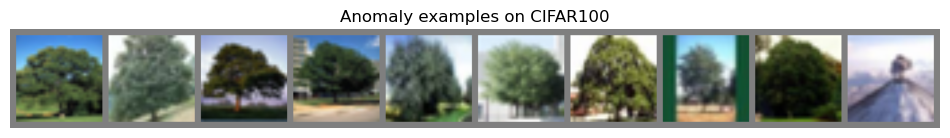

Prediction: 9


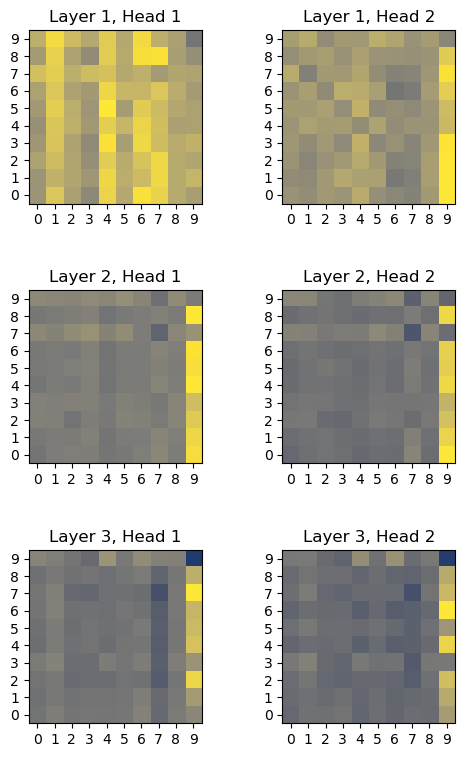

In [45]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

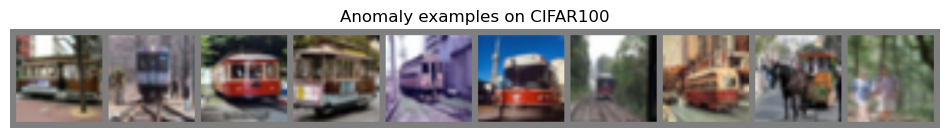

Prediction: 9


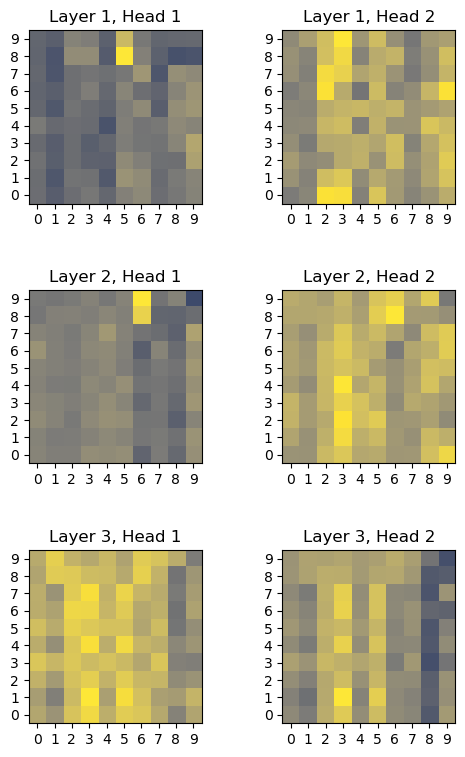

In [46]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(1)

In [47]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [  24   25   30   40   49   64   86   92   93  112  115  140  168  185
  197  202  221  250  267  269  275  284  301  302  310  333  336  339
  347  349  373  395  404  412  438  439  448  470  491  514  527  529
  537  551  561  590  600  603  609  616  638  642  644  654  660  663
  676  683  693  706  713  732  754  764  773  782  810  813  818  822
  847  872  881  884  936  948  949  957  993 1007]


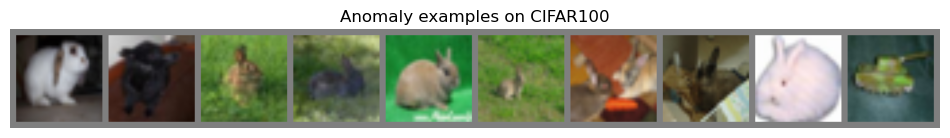

Prediction: 8


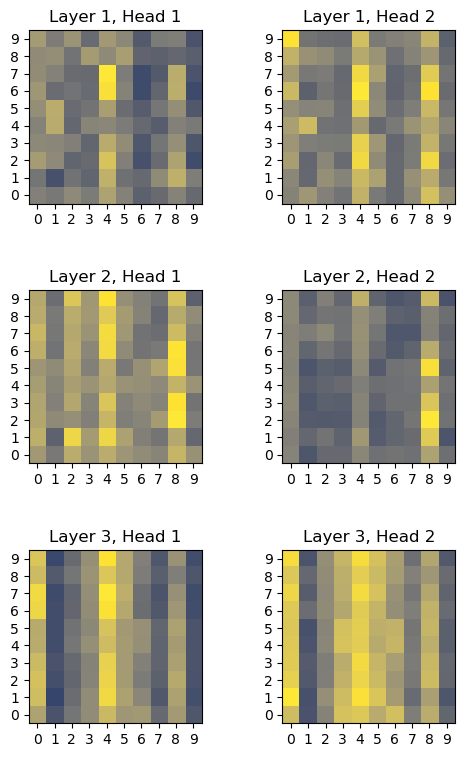

Probabilities:
Image 0: 0.31%
Image 1: 9.37%
Image 2: 1.83%
Image 3: 0.24%
Image 4: 0.43%
Image 5: 1.89%
Image 6: 4.58%
Image 7: 3.91%
Image 8: 68.02%
Image 9: 9.43%


In [48]:
if len(mistakes) >0:
    visualize_prediction(mistakes[-1])
    print("Probabilities:")
    for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
        print(f"Image {i}: {100.0*p:4.2f}%")
else:
    print("No mistakes")

TEST LOAD MODEL CREATED BY TORCH LIGTHNING WITH TORCH

In [13]:
import torch
from models.MLA_MOE.MLA_inference import ModelArgs,  Transformer

CHECKPOINT_PATH_FILE =  "C:\\Users\\Miguel\\Documents\\Malky\\research\\saved_models\\mla_Moe_anomalyDetection\\SetAnomalyTask\\lightning_logs\\version_0\\checkpoints\\epoch=47-step=2064.ckpt"



Since the model created by torch ligthing just save the weights. It is required to create a model. In this case, the model needs to be defined again.

In [20]:
class TransformerPredictor(nn.Module):

    def __init__(self, args):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
    
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        # self.save_hyperparameters()

        # dropout_out = kwargs.get("dropout_out", 0.1)
        # self.warmup = kwargs.get('warmup', 50)
        # self.max_iters = kwargs.get('max_iters', 50)
        # self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size

   
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x  = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps

In [21]:
dim = 512
n_routed_experts = 6

args = ModelArgs()

args.input_dim = train_anom_dataset.img_feats.shape[-1]             # Match ResNet output 512
args.max_batch_size = batch_size        # Larger batch size for stability in anomaly detection
args.max_seq_len = 512          # Match your embedding dimension (or adjust if needed)
args.vocab_size = 1             # Output detection
args.dim = dim                  # Match ResNet embedding dimension
args.inter_dim = dim  * 2         # Standard FFN expansion factor (2x dim)
args.n_layers = 3               # Deeper model for better feature learning
args.n_heads = 2               # Balanced attention heads


# LoRA (optional for efficiency)
args.q_lora_rank = 32          # Lower rank for LoRA (adjust if needed)
args.kv_lora_rank = 32
args.qk_nope_head_dim = 64       # Head dim without positional embeddings
args.qk_rope_head_dim = 64       # Head dim with RoPE
args.v_head_dim = 32         # Value head dim
args.dropout= 0.2             # Regularization for anomaly detection

# MoE Configuration (Key Focus)
args.n_routed_experts = n_routed_experts        # 4 routed experts (as requested)
args.n_shared_experts = 1        # 1 shared expert (as requested)
args.n_activated_experts = 3     # Activate 2 experts per token (common practice)
args.n_expert_groups = 1        # Single group unless you need parallelism
args.n_limited_groups = 1        # k groups 
args.score_func= "sigmoid"  # Standard choice
args.route_scale= 1.0         # No scaling
args.moe_inter_dim = (dim * 2 )// n_routed_experts
args.n_dense_layers = 1  # First layer is dense, second is MoE

In [22]:
model = TransformerPredictor(args=args)

In [23]:
torch.serialization.add_safe_globals([ModelArgs])
# Load the checkpoint with weights_only=False
checkpoint = torch.load(CHECKPOINT_PATH_FILE, weights_only=False)
# Extract the state_dict (model weights)
state_dict = checkpoint['state_dict']

In [24]:
model.load_state_dict(state_dict)
model =  model.to(device)
model.eval()  # Set to evaluation mode

TransformerPredictor(
  (transformer): Transformer(
    (embed): Linear(in_features=512, out_features=512, bias=True)
    (layers): ModuleList(
      (0): Block(
        (attn): MLA(
          (wq_a): Linear(in_features=512, out_features=32, bias=True)
          (q_norm): RMSNorm((32,), eps=None, elementwise_affine=True)
          (wq_b): Linear(in_features=32, out_features=128, bias=True)
          (wkv_a): Linear(in_features=512, out_features=32, bias=True)
          (kv_norm): RMSNorm((32,), eps=None, elementwise_affine=True)
          (wkv_b): Linear(in_features=32, out_features=192, bias=True)
          (wo): Linear(in_features=64, out_features=512, bias=True)
        )
        (ffn): MLP(
          (w1): Linear(in_features=512, out_features=1024, bias=True)
          (w2): Linear(in_features=1024, out_features=512, bias=True)
          (w3): Linear(in_features=512, out_features=1024, bias=True)
        )
        (attn_norm): RMSNorm((512,), eps=None, elementwise_affine=True)
    

Evaluate loaded model

In [25]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

with torch.no_grad():
    preds = model.forward(inp_data, mask=None, start_pos=0)
    preds = nn.functional.softmax(preds.squeeze(dim=-1), dim=-1)

print(preds)

tensor([[1.2715e-07, 5.8087e-08, 8.8766e-08,  ..., 1.9958e-07, 9.8171e-08,
         1.0000e+00],
        [8.5857e-05, 7.2985e-06, 1.3433e-05,  ..., 1.3075e-05, 7.8356e-02,
         9.1837e-01],
        [5.9543e-06, 1.4272e-05, 3.8129e-08,  ..., 4.8669e-08, 4.4227e-07,
         9.9998e-01],
        ...,
        [3.1029e-06, 2.6683e-08, 1.3621e-04,  ..., 1.0364e-07, 1.0397e-07,
         9.9986e-01],
        [7.1076e-08, 7.2597e-03, 4.4683e-09,  ..., 1.7337e-08, 1.5385e-06,
         7.7289e-01],
        [1.3003e-08, 2.3958e-08, 4.1828e-08,  ..., 1.2279e-08, 1.5952e-08,
         1.0000e+00]], device='cuda:0')


In [26]:
model.transformer.get_expert_assignments()

[(1, tensor([5688, 4629, 4600, 5676, 5516, 4611])),
 (2, tensor([5538, 4318, 5339, 4762, 6003, 4760]))]

In [27]:
attention_maps = model.get_attention_maps(inp_data, mask=None, start_pos=0)
predictions = preds.argmax(dim=-1)

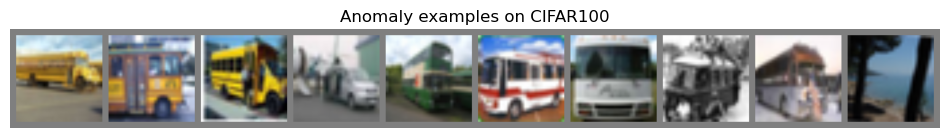

Prediction: 9


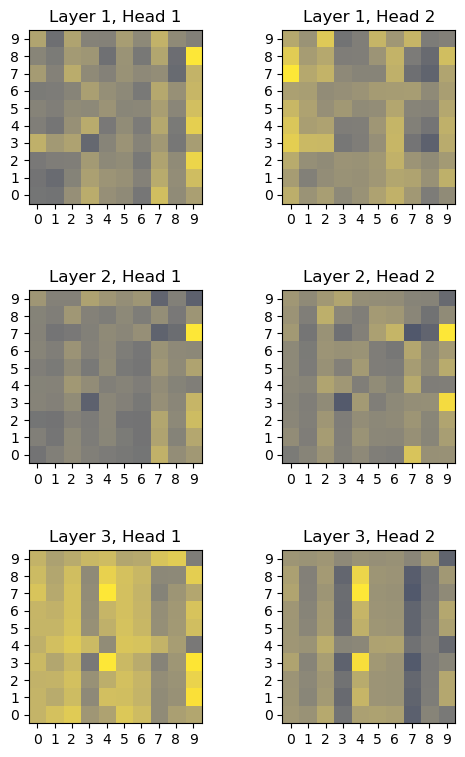

ground thruth tensor(9)


In [28]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(10)
print("ground thruth",labels[10])

Benchmark Model

In [29]:
import torch
import time

def benchmark_model(model, x, mask=None, n_runs=10, device="cuda"):
    """Benchmark the execution time of a PyTorch model."""

    model.to(device)
    x = x.to(device)
    if mask is not None:
        mask = mask.to(device)

    model.eval()  # Set model to evaluation mode
    
    
    # Warmup (for stable GPU benchmarking)
    with torch.no_grad():
        for _ in range(5):  
            _ = model(x, mask = mask, start_pos=0)

    # Timing execution
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(x, mask = mask, start_pos=0)
    end = time.time()

    avg_time = (end - start) / n_runs
    return avg_time


with absorb -> benchmarks the inference time of a PyTorch model using 10 runs 0.03925447463989258

In [30]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

b = benchmark_model(model, inp_data , mask=None, n_runs=10,  device="cuda")
print(f"benchmarks the inference time of a PyTorch model using {10} runs {b}")

benchmarks the inference time of a PyTorch model using 10 runs 0.03198220729827881


with naive

In [ ]:
# inp_data, indices, labels = next(iter(test_anom_loader))
# inp_data = inp_data.to(device)

# b = benchmark_model(model, inp_data , mask=None, n_runs=10,  device="cuda")
# print(f"benchmarks the inference time of a PyTorch model using {10} runs {b}")

benchmarks the inference time of a PyTorch model using 10 runs 0.05604419708251953
